In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
import rasterio as io

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [2]:
# Copyright (c) OpenMMLab. All rights reserved.
import warnings
from collections import OrderedDict
from copy import deepcopy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from mmcv.cnn import build_norm_layer
from mmcv.cnn.bricks.transformer import FFN, build_dropout
from mmengine.logging import print_log
from mmengine.model import BaseModule, ModuleList
from mmengine.model.weight_init import (constant_init, trunc_normal_,
                                        trunc_normal_init)
from mmengine.runner import CheckpointLoader
from mmengine.utils import to_2tuple

from mmseg.registry import MODELS
# from ..utils.embed import PatchEmbed, PatchMerging
import matplotlib.pyplot as plt





class WindowMSA(BaseModule):
    """Window based multi-head self-attention (W-MSA) module with relative
    position bias.

    Args:
        embed_dims (int): Number of input channels.
        num_heads (int): Number of attention heads.
        window_size (tuple[int]): The height and width of the window.
        qkv_bias (bool, optional):  If True, add a learnable bias to q, k, v.
            Default: True.
        qk_scale (float | None, optional): Override default qk scale of
            head_dim ** -0.5 if set. Default: None.
        attn_drop_rate (float, optional): Dropout ratio of attention weight.
            Default: 0.0
        proj_drop_rate (float, optional): Dropout ratio of output. Default: 0.
        init_cfg (dict | None, optional): The Config for initialization.
            Default: None.
    """

    def __init__(self,
                 embed_dims,
                 num_heads,
                 window_size,
                 qkv_bias=True,
                 qk_scale=None,
                 attn_drop_rate=0.,
                 proj_drop_rate=0.,
                 init_cfg=None):

        super().__init__(init_cfg=init_cfg)
        self.embed_dims = embed_dims
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_embed_dims = embed_dims // num_heads
        self.scale = qk_scale or head_embed_dims**-0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1),
                        num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        # Index buffer for relative position bias
        Wh, Ww = self.window_size
        rel_index_coords = self.double_step_seq(2 * Ww - 1, Wh, 1, Ww)
        rel_position_index = rel_index_coords + rel_index_coords.T
        rel_position_index = rel_position_index.flip(1).contiguous()
        self.register_buffer('relative_position_index', rel_position_index)

        self.qkv = nn.Linear(embed_dims, embed_dims * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop_rate)
        self.proj = nn.Linear(embed_dims, embed_dims)
        self.proj_drop = nn.Dropout(proj_drop_rate)

        self.softmax = nn.Softmax(dim=-1)

    def init_weights(self):
        trunc_normal_(self.relative_position_bias_table, std=0.02)

    def forward(self, x, mask=None, return_attention=False):
        """
        Args:

            x (tensor): input features with shape of (num_windows*B, N, C)
            mask (tensor | None, Optional): mask with shape of (num_windows,
                Wh*Ww, Wh*Ww), value should be between (-inf, 0].
        """
        
        # print('x.shape input of WindowMSA:________' ,x.shape)
        B, N, C = x.shape
        # print('x.shape of attention:________' ,x)
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads,
                                  C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[
            self.relative_position_index.view(-1)].view(
                self.window_size[0] * self.window_size[1],
                self.window_size[0] * self.window_size[1],
                -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(
            2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)

        attn = self.softmax(attn)
        
        if return_attention:
            self.saved_attention = attn.detach()

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        # print('x.shape of attention "the returned x value":________' ,x.shape)
        # print('x.shape of attention:________' ,x)
        return x

    @staticmethod
    def double_step_seq(step1, len1, step2, len2):
        seq1 = torch.arange(0, step1 * len1, step1)
        seq2 = torch.arange(0, step2 * len2, step2)
        return (seq1[:, None] + seq2[None, :]).reshape(1, -1)

    # def plot_attention_maps(self, head_idx=None):
    #     """
    #     Visualizes the attention maps.

    #     Args:
    #         head_idx (int, optional): Index of the specific head to visualize.
    #                                   If None, all heads are visualized.
    #     """
    #     if hasattr(self, 'saved_attention'):
    #         attention = self.saved_attention.squeeze(0)  # Assuming batch size of 1 for visualization
    #         num_heads = attention.shape[1]

    #         if head_idx is not None:
    #             # Visualize only the specified head's attention
    #             plt.figure(figsize=(10, 10))
    #             plt.imshow(attention[0, head_idx].cpu(), cmap='viridis')
    #             plt.colorbar()
    #             plt.title(f'Attention Map for Head {head_idx}')
    #             plt.show()
    #         else:
    #             # Visualize all heads
    #             fig, axes = plt.subplots(1, num_heads, figsize=(20, 10))
    #             for i in range(num_heads):
    #                 ax = axes[i]
    #                 im = ax.imshow(attention[0, i].cpu(), cmap='viridis')
    #                 ax.set_title(f'Head {i}')
    #             fig.colorbar(im, ax=axes.ravel().tolist())
    #             plt.show()
    #     else:
    #         print("No attention map has been saved. Please run the forward pass with return_attention=True.")


    # def plot_attention_maps(self, head_idx=None, save_path="D:\swin_sem_seg_8bands_sat_images_sent2\Swin_Semantic_segmentation_satellite_Data\work_dirs\attn_maps"):
    #     """
    #     Visualizes the attention maps and saves them as images.

    #     Args:
    #         head_idx (int, optional): Index of the specific head to visualize.
    #                                 If None, all heads are visualized.
    #         save_path (str): Directory to save the images.
    #     """
    #     import os
    #     if not os.path.exists(save_path):
    #         os.makedirs(save_path)

    #     if hasattr(self, 'saved_attention'):
    #         attention = self.saved_attention.squeeze(0)  # Assuming batch size of 1 for visualization
    #         num_heads = attention.shape[1]

    #         if head_idx is not None:
    #             # Visualize only the specified head's attention
    #             plt.figure(figsize=(10, 10))
    #             plt.imshow(attention[0, head_idx].cpu(), cmap='viridis')
    #             plt.colorbar()
    #             plt.title(f'Attention Map for Head {head_idx}')
    #             file_name = os.path.join(save_path, f'Head_{head_idx}.png')
    #             plt.savefig(file_name)
    #             plt.close()
    #             print(f"Saved attention map to {file_name}")
    #         else:
    #             # Visualize all heads
    #             for i in range(num_heads):
    #                 plt.figure(figsize=(10, 10))
    #                 plt.imshow(attention[0, i].cpu(), cmap='viridis')
    #                 plt.colorbar()
    #                 plt.title(f'Head {i}')
    #                 file_name = os.path.join(save_path, f'Head_{i}.png')
    #                 plt.savefig(file_name)
    #                 plt.close()
    #                 print(f"Saved attention map to {file_name}")
    #     else:
    #         print("No attention map has been saved. Please run the forward pass with return_attention=True.")


class ShiftWindowMSA(BaseModule):
    """Shifted Window Multihead Self-Attention Module.

    Args:
        embed_dims (int): Number of input channels.
        num_heads (int): Number of attention heads.
        window_size (int): The height and width of the window.
        shift_size (int, optional): The shift step of each window towards
            right-bottom. If zero, act as regular window-msa. Defaults to 0.
        qkv_bias (bool, optional): If True, add a learnable bias to q, k, v.
            Default: True
        qk_scale (float | None, optional): Override default qk scale of
            head_dim ** -0.5 if set. Defaults: None.
        attn_drop_rate (float, optional): Dropout ratio of attention weight.
            Defaults: 0.
        proj_drop_rate (float, optional): Dropout ratio of output.
            Defaults: 0.
        dropout_layer (dict, optional): The dropout_layer used before output.
            Defaults: dict(type='DropPath', drop_prob=0.).
        init_cfg (dict, optional): The extra config for initialization.
            Default: None.
    """

    def __init__(self,
                 embed_dims,
                 num_heads,
                 window_size,
                 shift_size=0,
                #  shift_size=3,

                 qkv_bias=True,
                 qk_scale=None,
                 attn_drop_rate=0,
                 proj_drop_rate=0,
                 dropout_layer=dict(type='DropPath', drop_prob=0.),
                 init_cfg=None):
        super().__init__(init_cfg=init_cfg)

        self.window_size = window_size
        self.shift_size = shift_size
        assert 0 <= self.shift_size < self.window_size

        self.w_msa = WindowMSA(
            embed_dims=embed_dims,
            num_heads=num_heads,
            window_size=to_2tuple(window_size),
            qkv_bias=qkv_bias,
            qk_scale=qk_scale,
            attn_drop_rate=attn_drop_rate,
            proj_drop_rate=proj_drop_rate,
            init_cfg=None)

        self.drop = build_dropout(dropout_layer)

    def forward(self, query, hw_shape):
        B, L, C = query.shape
        H, W = hw_shape
        assert L == H * W, 'input feature has wrong size'
        query = query.view(B, H, W, C)

        # pad feature maps to multiples of window size
        pad_r = (self.window_size - W % self.window_size) % self.window_size
        pad_b = (self.window_size - H % self.window_size) % self.window_size
        query = F.pad(query, (0, 0, 0, pad_r, 0, pad_b))
        H_pad, W_pad = query.shape[1], query.shape[2]

        # cyclic shift
        if self.shift_size > 0:
            # print('true, the shift_zise is larger than zero')
            shifted_query = torch.roll(
                query,
                shifts=(-self.shift_size, -self.shift_size),
                dims=(1, 2))

            # calculate attention mask for SW-MSA
            img_mask = torch.zeros((1, H_pad, W_pad, 1), device=query.device)
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size,
                              -self.shift_size), slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size,
                              -self.shift_size), slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1

            # nW, window_size, window_size, 1
            mask_windows = self.window_partition(img_mask)
            mask_windows = mask_windows.view(
                -1, self.window_size * self.window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0,
                                              float(-100.0)).masked_fill(
                                                  attn_mask == 0, float(0.0))
        else:
            # print('false not larger')
            shifted_query = query
            attn_mask = None

        # nW*B, window_size, window_size, C
        query_windows = self.window_partition(shifted_query)
        # nW*B, window_size*window_size, C
        query_windows = query_windows.view(-1, self.window_size**2, C)

        # W-MSA/SW-MSA (nW*B, window_size*window_size, C)
        attn_windows = self.w_msa(query_windows, mask=attn_mask)

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size,
                                         self.window_size, C)

        # B H' W' C
        shifted_x = self.window_reverse(attn_windows, H_pad, W_pad)
        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(
                shifted_x,
                shifts=(self.shift_size, self.shift_size),
                dims=(1, 2))
        else:
            x = shifted_x

        if pad_r > 0 or pad_b:
            x = x[:, :H, :W, :].contiguous()

        x = x.view(B, H * W, C)

        x = self.drop(x)
        # print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX: ",x)
        # print("attention from shiftedWindowMSA",x.shape)
        att_shape = x.shape
        att_tensor = x
        file_path='attn.txt'
        tensors = []
        # import time
        # timestamp = int(time.time() * 1000)  # Milliseconds since epoch
        
        # File path with timestamp
        # file_path = f'attention_tensors/tensor_data_{timestamp}.pt'
        
        # Save the tensor to a uniquely named file
        # torch.save(att_tensor, file_path)
        # with open (file_path,'a') as file:
        #     file.write(str(att_shape))
        #     file.write('\n')
        #     file.write(str(att_tensor))
        #     file.write('\n')
        
        return x

    def window_reverse(self, windows, H, W):
        """
        Args:
            windows: (num_windows*B, window_size, window_size, C)
            H (int): Height of image
            W (int): Width of image
        Returns:
            x: (B, H, W, C)
        """
        window_size = self.window_size
        B = int(windows.shape[0] / (H * W / window_size / window_size))
        x = windows.view(B, H // window_size, W // window_size, window_size,
                         window_size, -1)
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
        return x

    def window_partition(self, x):
        """
        Args:
            x: (B, H, W, C)
        Returns:
            windows: (num_windows*B, window_size, window_size, C)
        """
        B, H, W, C = x.shape
        # print('the shape of x at the beginning of the window partiotion',x.shape)
        # print('B:',B,'H:', H,'W', W,'C', C )
        window_size = self.window_size
        x = x.view(B, H // window_size, window_size, W // window_size,
                   window_size, C)
        windows = x.permute(0, 1, 3, 2, 4, 5).contiguous()
        windows = windows.view(-1, window_size, window_size, C)
        # print('the windows of the window partiotion',windows.shape)
        # print('the length o fwindows of the window partiotion',len(windows))

        return windows


class SwinBlock(BaseModule):
    """"
    Args:
        embed_dims (int): The feature dimension.
        num_heads (int): Parallel attention heads.
        feedforward_channels (int): The hidden dimension for FFNs.
        window_size (int, optional): The local window scale. Default: 7.
        shift (bool, optional): whether to shift window or not. Default False.
        qkv_bias (bool, optional): enable bias for qkv if True. Default: True.
        qk_scale (float | None, optional): Override default qk scale of
            head_dim ** -0.5 if set. Default: None.
        drop_rate (float, optional): Dropout rate. Default: 0.
        attn_drop_rate (float, optional): Attention dropout rate. Default: 0.
        drop_path_rate (float, optional): Stochastic depth rate. Default: 0.
        act_cfg (dict, optional): The config dict of activation function.
            Default: dict(type='GELU').
        norm_cfg (dict, optional): The config dict of normalization.
            Default: dict(type='LN').
        with_cp (bool, optional): Use checkpoint or not. Using checkpoint
            will save some memory while slowing down the training speed.
            Default: False.
        init_cfg (dict | list | None, optional): The init config.
            Default: None.
    """

    def __init__(self,
                 embed_dims,
                 num_heads,
                 feedforward_channels,
                 window_size=7,
                 shift=False,
                 qkv_bias=True,
                 qk_scale=None,
                 drop_rate=0.,
                 attn_drop_rate=0.,
                 drop_path_rate=0.,
                 act_cfg=dict(type='GELU'),
                 norm_cfg=dict(type='LN'),
                 with_cp=False,
                 init_cfg=None):

        super().__init__(init_cfg=init_cfg)

        self.with_cp = with_cp

        self.norm1 = build_norm_layer(norm_cfg, embed_dims)[1]
        # print('norm1',self.norm1)
        self.attn = ShiftWindowMSA(
            embed_dims=embed_dims,
            num_heads=num_heads,
            window_size=window_size,
            shift_size=window_size // 2 if shift else 0,
            qkv_bias=qkv_bias,
            qk_scale=qk_scale,
            attn_drop_rate=attn_drop_rate,
            proj_drop_rate=drop_rate,
            dropout_layer=dict(type='DropPath', drop_prob=drop_path_rate),
            init_cfg=None)
        # print('self.attn______',self.attn)
        self.norm2 = build_norm_layer(norm_cfg, embed_dims)[1]
        self.ffn = FFN(
            embed_dims=embed_dims,
            feedforward_channels=feedforward_channels,
            num_fcs=2,
            ffn_drop=drop_rate,
            dropout_layer=dict(type='DropPath', drop_prob=drop_path_rate),
            act_cfg=act_cfg,
            add_identity=True,
            init_cfg=None)

    def forward(self, x, hw_shape):

        def _inner_forward(x):
            # print('input x',x.shape)
            identity = x
            x = self.norm1(x)
            # print('x after norm 1',x.shape)
            x = self.attn(x, hw_shape)
            # print('x after attn',x.shape)
            x = x + identity
            # print('x after adding identity',x.shape)
            identity = x
            x = self.norm2(x)
            # print('x after adding norm2 ',x.shape)
            x = self.ffn(x, identity=identity)
            # print('x after adding ffn',x.shape)
            return x

        if self.with_cp and x.requires_grad:
            x = cp.checkpoint(_inner_forward, x)
        else:
            x = _inner_forward(x)

        return x


class SwinBlockSequence(BaseModule):
    """Implements one stage in Swin Transformer.

    Args:
        embed_dims (int): The feature dimension.
        num_heads (int): Parallel attention heads.
        feedforward_channels (int): The hidden dimension for FFNs.
        depth (int): The number of blocks in this stage.
        window_size (int, optional): The local window scale. Default: 7.
        qkv_bias (bool, optional): enable bias for qkv if True. Default: True.
        qk_scale (float | None, optional): Override default qk scale of
            head_dim ** -0.5 if set. Default: None.
        drop_rate (float, optional): Dropout rate. Default: 0.
        attn_drop_rate (float, optional): Attention dropout rate. Default: 0.
        drop_path_rate (float | list[float], optional): Stochastic depth
            rate. Default: 0.
        downsample (BaseModule | None, optional): The downsample operation
            module. Default: None.
        act_cfg (dict, optional): The config dict of activation function.
            Default: dict(type='GELU').
        norm_cfg (dict, optional): The config dict of normalization.
            Default: dict(type='LN').
        with_cp (bool, optional): Use checkpoint or not. Using checkpoint
            will save some memory while slowing down the training speed.
            Default: False.
        init_cfg (dict | list | None, optional): The init config.
            Default: None.
    """

    def __init__(self,
                 embed_dims,
                 num_heads,
                 feedforward_channels,
                 depth,
                 window_size=7,
                 qkv_bias=True,
                 qk_scale=None,
                 drop_rate=0.,
                 attn_drop_rate=0.,
                 drop_path_rate=0.,
                 downsample=None,
                 act_cfg=dict(type='GELU'),
                 norm_cfg=dict(type='LN'),
                 with_cp=False,
                 init_cfg=None):
        super().__init__(init_cfg=init_cfg)

        if isinstance(drop_path_rate, list):
            drop_path_rates = drop_path_rate
            assert len(drop_path_rates) == depth
        else:
            drop_path_rates = [deepcopy(drop_path_rate) for _ in range(depth)]

        self.blocks = ModuleList()
        for i in range(depth):
            block = SwinBlock(
                embed_dims=embed_dims,
                num_heads=num_heads,
                feedforward_channels=feedforward_channels,
                window_size=window_size,
                shift=False if i % 2 == 0 else True,
                qkv_bias=qkv_bias,
                qk_scale=qk_scale,
                drop_rate=drop_rate,
                attn_drop_rate=attn_drop_rate,
                drop_path_rate=drop_path_rates[i],
                act_cfg=act_cfg,
                norm_cfg=norm_cfg,
                with_cp=with_cp,
                init_cfg=None)
            self.blocks.append(block)

        self.downsample = downsample

    def forward(self, x, hw_shape):
        for block in self.blocks:
            x = block(x, hw_shape)
            # print(x)
            # print('x.shape',x.shape)

        if self.downsample:
            x_down, down_hw_shape = self.downsample(x, hw_shape)
            # print('x_down',x_down)
            # print('hw_shape',hw_shape)

            return x_down, down_hw_shape, x, hw_shape
        else:
            return x, hw_shape, x, hw_shape


# @MODELS.register_module()
class SwinTransformer(BaseModule):
    """Swin Transformer backbone.

    This backbone is the implementation of `Swin Transformer:
    Hierarchical Vision Transformer using Shifted
    Windows <https://arxiv.org/abs/2103.14030>`_.
    Inspiration from https://github.com/microsoft/Swin-Transformer.

    Args:
        pretrain_img_size (int | tuple[int]): The size of input image when
            pretrain. Defaults: 224.
        in_channels (int): The num of input channels.
            Defaults: 3.
        embed_dims (int): The feature dimension. Default: 96.
        patch_size (int | tuple[int]): Patch size. Default: 4.
        window_size (int): Window size. Default: 7.
        mlp_ratio (int | float): Ratio of mlp hidden dim to embedding dim.
            Default: 4.
        depths (tuple[int]): Depths of each Swin Transformer stage.
            Default: (2, 2, 6, 2).
        num_heads (tuple[int]): Parallel attention heads of each Swin
            Transformer stage. Default: (3, 6, 12, 24).
        strides (tuple[int]): The patch merging or patch embedding stride of
            each Swin Transformer stage. (In swin, we set kernel size equal to
            stride.) Default: (4, 2, 2, 2).
        out_indices (tuple[int]): Output from which stages.
            Default: (0, 1, 2, 3).
        qkv_bias (bool, optional): If True, add a learnable bias to query, key,
            value. Default: True
        qk_scale (float | None, optional): Override default qk scale of
            head_dim ** -0.5 if set. Default: None.
        patch_norm (bool): If add a norm layer for patch embed and patch
            merging. Default: True.
        drop_rate (float): Dropout rate. Defaults: 0.
        attn_drop_rate (float): Attention dropout rate. Default: 0.
        drop_path_rate (float): Stochastic depth rate. Defaults: 0.1.
        use_abs_pos_embed (bool): If True, add absolute position embedding to
            the patch embedding. Defaults: False.
        act_cfg (dict): Config dict for activation layer.
            Default: dict(type='LN').
        norm_cfg (dict): Config dict for normalization layer at
            output of backone. Defaults: dict(type='LN').
        with_cp (bool, optional): Use checkpoint or not. Using checkpoint
            will save some memory while slowing down the training speed.
            Default: False.
        pretrained (str, optional): model pretrained path. Default: None.
        frozen_stages (int): Stages to be frozen (stop grad and set eval mode).
            -1 means not freezing any parameters.
        init_cfg (dict, optional): The Config for initialization.
            Defaults to None.
    """
    # file_path = 'D:\swin_sem_seg_8bands_sat_images_sent2\Swin_Semantic_segmentation_satellite_Data\mmsegmentation\my_dataset_8bands'
    def __init__(self,
                 pretrain_img_size=224,
                 in_channels=3,
                 embed_dims=96,
                 patch_size=4,
                 window_size=7,
                 mlp_ratio=4,
                 depths=(2, 2, 6, 2),
                 num_heads=(3, 6, 12, 24),
                 strides=(4, 2, 2, 2),
                 out_indices=(0, 1, 2, 3),
                 qkv_bias=True,
                 qk_scale=None,
                 patch_norm=True,
                 drop_rate=0.,
                 attn_drop_rate=0.,
                 drop_path_rate=0.1,
                 use_abs_pos_embed=False,
                 act_cfg=dict(type='GELU'),
                 norm_cfg=dict(type='LN'),
                 with_cp=False,
                 pretrained=None,
                 frozen_stages=-1,
                 init_cfg=None):
        self.frozen_stages = frozen_stages

        if isinstance(pretrain_img_size, int):
            pretrain_img_size = to_2tuple(pretrain_img_size)
        elif isinstance(pretrain_img_size, tuple):
            if len(pretrain_img_size) == 1:
                pretrain_img_size = to_2tuple(pretrain_img_size[0])
            assert len(pretrain_img_size) == 2, \
                f'The size of image should have length 1 or 2, ' \
                f'but got {len(pretrain_img_size)}'

        assert not (init_cfg and pretrained), \
            'init_cfg and pretrained cannot be specified at the same time'
        if isinstance(pretrained, str):
            warnings.warn('DeprecationWarning: pretrained is deprecated, '
                          'please use "init_cfg" instead')
            init_cfg = dict(type='Pretrained', checkpoint=pretrained)
        elif pretrained is None:
            init_cfg = init_cfg
        else:
            raise TypeError('pretrained must be a str or None')

        super().__init__(init_cfg=init_cfg)

        num_layers = len(depths)
        self.out_indices = out_indices
        self.use_abs_pos_embed = use_abs_pos_embed

        assert strides[0] == patch_size, 'Use non-overlapping patch embed.'

        self.patch_embed = PatchEmbed(
            in_channels=in_channels,
            embed_dims=embed_dims,
            conv_type='Conv2d',
            kernel_size=patch_size,
            stride=strides[0],
            padding='corner',
            norm_cfg=norm_cfg if patch_norm else None,
            init_cfg=None)

        if self.use_abs_pos_embed:
            patch_row = pretrain_img_size[0] // patch_size
            patch_col = pretrain_img_size[1] // patch_size
            num_patches = patch_row * patch_col
            self.absolute_pos_embed = nn.Parameter(
                torch.zeros((1, num_patches, embed_dims)))

        self.drop_after_pos = nn.Dropout(p=drop_rate)

        # set stochastic depth decay rule
        total_depth = sum(depths)
        dpr = [
            x.item() for x in torch.linspace(0, drop_path_rate, total_depth)
        ]

        self.stages = ModuleList()
        in_channels = embed_dims
        for i in range(num_layers):
            if i < num_layers - 1:
                downsample = PatchMerging(
                    in_channels=in_channels,
                    out_channels=2 * in_channels,
                    stride=strides[i + 1],
                    norm_cfg=norm_cfg if patch_norm else None,
                    init_cfg=None)
            else:
                downsample = None

            stage = SwinBlockSequence(
                embed_dims=in_channels,
                num_heads=num_heads[i],
                feedforward_channels=int(mlp_ratio * in_channels),
                depth=depths[i],
                window_size=window_size,
                qkv_bias=qkv_bias,
                qk_scale=qk_scale,
                drop_rate=drop_rate,
                attn_drop_rate=attn_drop_rate,
                drop_path_rate=dpr[sum(depths[:i]):sum(depths[:i + 1])],
                downsample=downsample,
                act_cfg=act_cfg,
                norm_cfg=norm_cfg,
                with_cp=with_cp,
                init_cfg=None)
            self.stages.append(stage)
            if downsample:
                in_channels = downsample.out_channels

        self.num_features = [int(embed_dims * 2**i) for i in range(num_layers)]
        # Add a norm layer for each output
        for i in out_indices:
            layer = build_norm_layer(norm_cfg, self.num_features[i])[1]
            layer_name = f'norm{i}'
            self.add_module(layer_name, layer)

    def train(self, mode=True):
        """Convert the model into training mode while keep layers freezed."""
        super().train(mode)
        self._freeze_stages()

    def _freeze_stages(self):
        if self.frozen_stages >= 0:
            self.patch_embed.eval()
            for param in self.patch_embed.parameters():
                param.requires_grad = False
            if self.use_abs_pos_embed:
                self.absolute_pos_embed.requires_grad = False
            self.drop_after_pos.eval()

        for i in range(1, self.frozen_stages + 1):

            if (i - 1) in self.out_indices:
                norm_layer = getattr(self, f'norm{i-1}')
                norm_layer.eval()
                for param in norm_layer.parameters():
                    param.requires_grad = False

            m = self.stages[i - 1]
            m.eval()
            for param in m.parameters():
                param.requires_grad = False

    def init_weights(self):
        if self.init_cfg is None:
            print_log(f'No pre-trained weights for '
                      f'{self.__class__.__name__}, '
                      f'training start from scratch')
            if self.use_abs_pos_embed:
                trunc_normal_(self.absolute_pos_embed, std=0.02)
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    trunc_normal_init(m, std=.02, bias=0.)
                elif isinstance(m, nn.LayerNorm):
                    constant_init(m, val=1.0, bias=0.)
        else:
            assert 'checkpoint' in self.init_cfg, f'Only support ' \
                                                  f'specify `Pretrained` in ' \
                                                  f'`init_cfg` in ' \
                                                  f'{self.__class__.__name__} '
            ckpt = CheckpointLoader.load_checkpoint(
                self.init_cfg['checkpoint'], logger=None, map_location='cpu')
            if 'state_dict' in ckpt:
                _state_dict = ckpt['state_dict']
            elif 'model' in ckpt:
                _state_dict = ckpt['model']
            else:
                _state_dict = ckpt

            state_dict = OrderedDict()
            for k, v in _state_dict.items():
                if k.startswith('backbone.'):
                    state_dict[k[9:]] = v
                else:
                    state_dict[k] = v

            # strip prefix of state_dict
            if list(state_dict.keys())[0].startswith('module.'):
                state_dict = {k[7:]: v for k, v in state_dict.items()}

            # reshape absolute position embedding
            if state_dict.get('absolute_pos_embed') is not None:
                absolute_pos_embed = state_dict['absolute_pos_embed']
                N1, L, C1 = absolute_pos_embed.size()
                N2, C2, H, W = self.absolute_pos_embed.size()
                if N1 != N2 or C1 != C2 or L != H * W:
                    print_log('Error in loading absolute_pos_embed, pass')
                else:
                    state_dict['absolute_pos_embed'] = absolute_pos_embed.view(
                        N2, H, W, C2).permute(0, 3, 1, 2).contiguous()

            # interpolate position bias table if needed
            relative_position_bias_table_keys = [
                k for k in state_dict.keys()
                if 'relative_position_bias_table' in k
            ]
            for table_key in relative_position_bias_table_keys:
                table_pretrained = state_dict[table_key]
                if table_key in self.state_dict():
                    table_current = self.state_dict()[table_key]
                    L1, nH1 = table_pretrained.size()
                    L2, nH2 = table_current.size()
                    if nH1 != nH2:
                        print_log(f'Error in loading {table_key}, pass')
                    elif L1 != L2:
                        S1 = int(L1**0.5)
                        S2 = int(L2**0.5)
                        table_pretrained_resized = F.interpolate(
                            table_pretrained.permute(1, 0).reshape(
                                1, nH1, S1, S1),
                            size=(S2, S2),
                            mode='bicubic')
                        state_dict[table_key] = table_pretrained_resized.view(
                            nH2, L2).permute(1, 0).contiguous()

            # load state_dict
            self.load_state_dict(state_dict, strict=False)

    def forward(self, x):
        x, hw_shape = self.patch_embed(x)

        if self.use_abs_pos_embed:
            x = x + self.absolute_pos_embed
        x = self.drop_after_pos(x)

        outs = []
        for i, stage in enumerate(self.stages):
            x, hw_shape, out, out_hw_shape = stage(x, hw_shape)
            # indx =f"stage: {i}"
            # file_path='attn.txt'
            # with open (file_path,'a') as file:
            #     file.write(indx)
            #     file.write('\n')
            #     file.write('\n')
            #     file.write('\n')
            # print('stage no:___',i)
            if i in self.out_indices:
                norm_layer = getattr(self, f'norm{i}')
                out = norm_layer(out)
                out = out.view(-1, *out_hw_shape,
                               self.num_features[i]).permute(0, 3, 1,
                                                             2).contiguous()
                outs.append(out)
                # print(out.shape)
                # print(out)
        # # print('--------------------_________________-----------------',outs[0])
        # print('--------------------_________________-----------------',outs[0].shape)
        #         # print('--------------------_________________-----------------',outs[1])
        # print('--------------------_________________-----------------',outs[1].shape)
        #         # print('--------------------_________________-----------------',outs[2])
        # print('--------------------_________________-----------------',outs[2].shape)
        #         # print('--------------------_________________-----------------',outs[3])
        # print('--------------------_________________-----------------',outs[3].shape)
        
        # print('--------------------_________________-----------------',outs[0].size)
        return outs


2024-06-24 23:50:18.499470: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
# # Check if CUDA is available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f'Running on device: {device}')

In [4]:
# Copyright (c) OpenMMLab. All rights reserved.
import math
from typing import Sequence

import torch.nn as nn
import torch.nn.functional as F
from mmcv.cnn import build_conv_layer, build_norm_layer
from mmengine.model import BaseModule
from mmengine.utils import to_2tuple


class AdaptivePadding(nn.Module):
    """Applies padding to input (if needed) so that input can get fully covered
    by filter you specified. It support two modes "same" and "corner". The
    "same" mode is same with "SAME" padding mode in TensorFlow, pad zero around
    input. The "corner"  mode would pad zero to bottom right.

    Args:
        kernel_size (int | tuple): Size of the kernel:
        stride (int | tuple): Stride of the filter. Default: 1:
        dilation (int | tuple): Spacing between kernel elements.
            Default: 1.
        padding (str): Support "same" and "corner", "corner" mode
            would pad zero to bottom right, and "same" mode would
            pad zero around input. Default: "corner".
    Example:
        >>> kernel_size = 16
        >>> stride = 16
        >>> dilation = 1
        >>> input = torch.rand(1, 1, 15, 17)
        >>> adap_pad = AdaptivePadding(
        >>>     kernel_size=kernel_size,
        >>>     stride=stride,
        >>>     dilation=dilation,
        >>>     padding="corner")
        >>> out = adap_pad(input)
        >>> assert (out.shape[2], out.shape[3]) == (16, 32)
        >>> input = torch.rand(1, 1, 16, 17)
        >>> out = adap_pad(input)
        >>> assert (out.shape[2], out.shape[3]) == (16, 32)
    """

    def __init__(self, kernel_size=1, stride=1, dilation=1, padding='corner'):

        super().__init__()

        assert padding in ('same', 'corner')

        kernel_size = to_2tuple(kernel_size)
        stride = to_2tuple(stride)
        dilation = to_2tuple(dilation)

        self.padding = padding
        self.kernel_size = kernel_size
        self.stride = stride
        self.dilation = dilation

    def get_pad_shape(self, input_shape):
        input_h, input_w = input_shape
        kernel_h, kernel_w = self.kernel_size
        stride_h, stride_w = self.stride
        output_h = math.ceil(input_h / stride_h)
        output_w = math.ceil(input_w / stride_w)
        pad_h = max((output_h - 1) * stride_h +
                    (kernel_h - 1) * self.dilation[0] + 1 - input_h, 0)
        pad_w = max((output_w - 1) * stride_w +
                    (kernel_w - 1) * self.dilation[1] + 1 - input_w, 0)
        return pad_h, pad_w

    def forward(self, x):
        pad_h, pad_w = self.get_pad_shape(x.size()[-2:])
        if pad_h > 0 or pad_w > 0:
            if self.padding == 'corner':
                x = F.pad(x, [0, pad_w, 0, pad_h])
            elif self.padding == 'same':
                x = F.pad(x, [
                    pad_w // 2, pad_w - pad_w // 2, pad_h // 2,
                    pad_h - pad_h // 2
                ])
        return x


class PatchEmbed(BaseModule):
    """Image to Patch Embedding.

    We use a conv layer to implement PatchEmbed.

    Args:
        in_channels (int): The num of input channels. Default: 3
        embed_dims (int): The dimensions of embedding. Default: 768
        conv_type (str): The config dict for embedding
            conv layer type selection. Default: "Conv2d".
        kernel_size (int): The kernel_size of embedding conv. Default: 16.
        stride (int, optional): The slide stride of embedding conv.
            Default: None (Would be set as `kernel_size`).
        padding (int | tuple | string ): The padding length of
            embedding conv. When it is a string, it means the mode
            of adaptive padding, support "same" and "corner" now.
            Default: "corner".
        dilation (int): The dilation rate of embedding conv. Default: 1.
        bias (bool): Bias of embed conv. Default: True.
        norm_cfg (dict, optional): Config dict for normalization layer.
            Default: None.
        input_size (int | tuple | None): The size of input, which will be
            used to calculate the out size. Only work when `dynamic_size`
            is False. Default: None.
        init_cfg (`mmengine.ConfigDict`, optional): The Config for
            initialization. Default: None.
    """

    def __init__(self,
                 in_channels=3,
                 embed_dims=768,
                 conv_type='Conv2d',
                 kernel_size=16,
                 stride=None,
                 padding='corner',
                 dilation=1,
                 bias=True,
                 norm_cfg=None,
                 input_size=None,
                 init_cfg=None):
        super().__init__(init_cfg=init_cfg)

        self.embed_dims = embed_dims
        if stride is None:
            stride = kernel_size

        kernel_size = to_2tuple(kernel_size)
        stride = to_2tuple(stride)
        dilation = to_2tuple(dilation)

        if isinstance(padding, str):
            self.adap_padding = AdaptivePadding(
                kernel_size=kernel_size,
                stride=stride,
                dilation=dilation,
                padding=padding)
            # disable the padding of conv
            padding = 0
        else:
            self.adap_padding = None
        padding = to_2tuple(padding)

        self.projection = build_conv_layer(
            dict(type=conv_type),
            in_channels=in_channels,
            out_channels=embed_dims,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            bias=bias)

        if norm_cfg is not None:
            self.norm = build_norm_layer(norm_cfg, embed_dims)[1]
        else:
            self.norm = None

        if input_size:
            input_size = to_2tuple(input_size)
            # `init_out_size` would be used outside to
            # calculate the num_patches
            # when `use_abs_pos_embed` outside
            self.init_input_size = input_size
            if self.adap_padding:
                pad_h, pad_w = self.adap_padding.get_pad_shape(input_size)
                input_h, input_w = input_size
                input_h = input_h + pad_h
                input_w = input_w + pad_w
                input_size = (input_h, input_w)

            # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
            h_out = (input_size[0] + 2 * padding[0] - dilation[0] *
                     (kernel_size[0] - 1) - 1) // stride[0] + 1
            w_out = (input_size[1] + 2 * padding[1] - dilation[1] *
                     (kernel_size[1] - 1) - 1) // stride[1] + 1
            self.init_out_size = (h_out, w_out)
        else:
            self.init_input_size = None
            self.init_out_size = None

    def forward(self, x):
        """
        Args:
            x (Tensor): Has shape (B, C, H, W). In most case, C is 3.

        Returns:
            tuple: Contains merged results and its spatial shape.

                - x (Tensor): Has shape (B, out_h * out_w, embed_dims)
                - out_size (tuple[int]): Spatial shape of x, arrange as
                    (out_h, out_w).
        """

        if self.adap_padding:
            x = self.adap_padding(x)

        x = self.projection(x)
        out_size = (x.shape[2], x.shape[3])
        x = x.flatten(2).transpose(1, 2)
        if self.norm is not None:
            x = self.norm(x)
        return x, out_size


class PatchMerging(BaseModule):
    """Merge patch feature map.

    This layer groups feature map by kernel_size, and applies norm and linear
    layers to the grouped feature map. Our implementation uses `nn.Unfold` to
    merge patch, which is about 25% faster than original implementation.
    Instead, we need to modify pretrained models for compatibility.

    Args:
        in_channels (int): The num of input channels.
        out_channels (int): The num of output channels.
        kernel_size (int | tuple, optional): the kernel size in the unfold
            layer. Defaults to 2.
        stride (int | tuple, optional): the stride of the sliding blocks in the
            unfold layer. Default: None. (Would be set as `kernel_size`)
        padding (int | tuple | string ): The padding length of
            embedding conv. When it is a string, it means the mode
            of adaptive padding, support "same" and "corner" now.
            Default: "corner".
        dilation (int | tuple, optional): dilation parameter in the unfold
            layer. Default: 1.
        bias (bool, optional): Whether to add bias in linear layer or not.
            Defaults: False.
        norm_cfg (dict, optional): Config dict for normalization layer.
            Default: dict(type='LN').
        init_cfg (dict, optional): The extra config for initialization.
            Default: None.
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=2,
                 stride=None,
                 padding='corner',
                 dilation=1,
                 bias=False,
                 norm_cfg=dict(type='LN'),
                 init_cfg=None):
        super().__init__(init_cfg=init_cfg)
        self.in_channels = in_channels
        self.out_channels = out_channels
        if stride:
            stride = stride
        else:
            stride = kernel_size

        kernel_size = to_2tuple(kernel_size)
        stride = to_2tuple(stride)
        dilation = to_2tuple(dilation)

        if isinstance(padding, str):
            self.adap_padding = AdaptivePadding(
                kernel_size=kernel_size,
                stride=stride,
                dilation=dilation,
                padding=padding)
            # disable the padding of unfold
            padding = 0
        else:
            self.adap_padding = None

        padding = to_2tuple(padding)
        self.sampler = nn.Unfold(
            kernel_size=kernel_size,
            dilation=dilation,
            padding=padding,
            stride=stride)

        sample_dim = kernel_size[0] * kernel_size[1] * in_channels

        if norm_cfg is not None:
            self.norm = build_norm_layer(norm_cfg, sample_dim)[1]
        else:
            self.norm = None

        self.reduction = nn.Linear(sample_dim, out_channels, bias=bias)

    def forward(self, x, input_size):
        """
        Args:
            x (Tensor): Has shape (B, H*W, C_in).
            input_size (tuple[int]): The spatial shape of x, arrange as (H, W).
                Default: None.

        Returns:
            tuple: Contains merged results and its spatial shape.

                - x (Tensor): Has shape (B, Merged_H * Merged_W, C_out)
                - out_size (tuple[int]): Spatial shape of x, arrange as
                    (Merged_H, Merged_W).
        """
        B, L, C = x.shape
        assert isinstance(input_size, Sequence), f'Expect ' \
                                                 f'input_size is ' \
                                                 f'`Sequence` ' \
                                                 f'but get {input_size}'

        H, W = input_size
        assert L == H * W, 'input feature has wrong size'

        x = x.view(B, H, W, C).permute([0, 3, 1, 2])  # B, C, H, W
        # Use nn.Unfold to merge patch. About 25% faster than original method,
        # but need to modify pretrained model for compatibility

        if self.adap_padding:
            x = self.adap_padding(x)
            H, W = x.shape[-2:]

        x = self.sampler(x)
        # if kernel_size=2 and stride=2, x should has shape (B, 4*C, H/2*W/2)

        out_h = (H + 2 * self.sampler.padding[0] - self.sampler.dilation[0] *
                 (self.sampler.kernel_size[0] - 1) -
                 1) // self.sampler.stride[0] + 1
        out_w = (W + 2 * self.sampler.padding[1] - self.sampler.dilation[1] *
                 (self.sampler.kernel_size[1] - 1) -
                 1) // self.sampler.stride[1] + 1

        output_size = (out_h, out_w)
        x = x.transpose(1, 2)  # B, H/2*W/2, 4*C
        x = self.norm(x) if self.norm else x
        x = self.reduction(x)
        return x, output_size


In [5]:
# Define transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    # transforms.ConvertImageDtype(torch.float64)  # Convert input data to double precision
])

In [6]:
# Define dataset class
class CombinedDataset(Dataset):
    def __init__(self, img_dir, target_dir,csv_file, transform=None, mode='train'):
        self.img_dir = img_dir
        self.target_dir = target_dir

        self.csv_data = pd.read_csv(csv_file)
        self.transform = transform
        self.mode = mode


        # List only .tif files for both images and targets
        self.image_files = [f for f in os.listdir(img_dir) if f.endswith('.tif')]
        self.target_files = [f for f in os.listdir(target_dir) if f.endswith('.tif')]

        # Optional: Match image files and target files explicitly
        self.image_files = [f for f in self.image_files if f in self.target_files]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.csv_data.iloc[idx, 1] + ".tif")
        ann_name = os.path.join(self.target_dir, self.csv_data.iloc[idx, 1] + ".tif")
        n=self.csv_data.iloc[idx, 1]
        # print("n:", n)
        with io.open(img_name) as src:
            sent2_image = src.read().astype('float32')  # Read image as float64
        
        with io.open(ann_name) as src:
            ann_image = src.read().astype('float32')

        soy_yield_normalized= self.csv_data.iloc[idx, 6]  # First crop yield value
        corn_yield_normalized = self.csv_data.iloc[idx, 7]  # Second crop yield value
        
        if self.transform:
            # image = self.transform(image)
            p=5
        if self.mode == 'test':
            return sent2_image,ann_image, (corn_yield_normalized, soy_yield_normalized)
        else:
            return sent2_image, ann_image, (torch.tensor(corn_yield_normalized, dtype=torch.float32), torch.tensor(soy_yield_normalized, dtype=torch.float32))

In [7]:

img_train = r"/home/jovyan/Thesis/Models_training/Full_Data/Normalized_Data/img_dir/train_2"
img_val = r"/home/jovyan/Thesis/Models_training/Full_Data/Normalized_Data/img_dir/val_2"
img_test = r"/home/jovyan/Thesis/Models_training/Full_Data/Normalized_Data/img_dir/test2"
# img_test = r"/home/jovyan/Thesis/Models_training/Full_Data/Full_correct_data/img_dir/test6"

ann_train = r"/home/jovyan/Thesis/Models_training/Full_Data/Normalized_Data/ann_dir/train_2"
ann_val = r"/home/jovyan/Thesis/Models_training/Full_Data/Normalized_Data/ann_dir/val_2"
ann_test = r"/home/jovyan/Thesis/Models_training/Full_Data/Normalized_Data/ann_dir/test2"
# ann_test = r"/home/jovyan/Thesis/Models_training/Full_Data/Full_correct_data/ann_dir/test6"

crop_train = r"/home/jovyan/Thesis/Models_training/Full_Data/Normalized_Data/ann_dir/train_2/normalized_train_yield.csv"
crop_val = r"/home/jovyan/Thesis/Models_training/Full_Data/Normalized_Data/ann_dir/val_2/normalized_val_yield.csv"
crop_test = r"/home/jovyan/Thesis/Models_training/Full_Data/Normalized_Data/ann_dir/test2/normalized_test_yield.csv"
# crop_test = r"/home/jovyan/Thesis/Models_training/Full_Data/Full_correct_data/ann_dir/test6/normalized_test_yield.csv"







In [8]:
dataset_train = CombinedDataset(img_train, ann_train,crop_train, transform=transform)
dataset_val = CombinedDataset(img_val, ann_val,crop_val, transform=transform)
dataset_test = CombinedDataset(img_test, ann_test,crop_test, transform=transform)

In [9]:
# Move data loaders to GPU
train_loader = DataLoader(dataset_train, batch_size=40, shuffle=True, pin_memory=True)
val_loader = DataLoader(dataset_val, batch_size=40, shuffle=True, pin_memory=True)
test_loader = DataLoader(dataset_test, batch_size=40, shuffle=True, pin_memory=True)
# train_loader = DataLoader(dataset_train, batch_size=40, shuffle=True, num_workers=4, collate_fn=None)
# val_loader = DataLoader(dataset_val, batch_size=4, shuffle=False, num_workers=4, collate_fn=None)


In [16]:
# # test_loader = DataLoader(dataset_test, batch_size=1, shuffle=True, pin_memory=True)

# # for images , targets ,yields in test_loader:
# #     # print(name)
# #     print(images.shape)
# #     print(targets.shape)
# #     # print(len(g))
# #     print(yields)
   
# #     break

# for i, j, k, l in test_loader:
#     print(5)
#     print(l)
#     break

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

class SegmentationHead(nn.Module):
    def __init__(self, num_classes):
        super(SegmentationHead, self).__init__()
        self.upsample1 = nn.ConvTranspose2d(768, 384, kernel_size=2, stride=2)
        self.upsample2 = nn.ConvTranspose2d(768, 192, kernel_size=2, stride=2)
        self.upsample3 = nn.ConvTranspose2d(384, 96, kernel_size=2, stride=2)
        self.final_upsample = nn.ConvTranspose2d(192, num_classes, kernel_size=4, stride=4)

    def forward(self, features):
        # features is a list of feature maps from different stages
        stage0, stage1, stage2, stage3 = features

        x = self.upsample1(stage3)  # Upsample stage 3 output
        x = torch.cat([x, stage2], dim=1)  # Concatenate with stage 2 output

        x = self.upsample2(x)  # Upsample
        x = torch.cat([x, stage1], dim=1)  # Concatenate with stage 1 output

        x = self.upsample3(x)  # Upsample
        x = torch.cat([x, stage0], dim=1)  # Concatenate with stage 0 output

        x = self.final_upsample(x)  # Final upsampling to get the segmentation map
        return x

class RegressionHead(nn.Module):
    def __init__(self, input_dims):
        super(RegressionHead, self).__init__()
        self.fc1 = nn.Linear(sum(input_dims), 512)
        self.fc2 = nn.Linear(512, 128)
        
        # Separate layers for corn and soybean
        self.corn_fc3 = nn.Linear(128, 64)
        self.corn_fc4 = nn.Linear(64, 1)
        
        self.soybean_fc3 = nn.Linear(128, 64)
        self.soybean_fc4 = nn.Linear(64, 1)
        
        self.relu = nn.ReLU()
        # self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        
        # Forward pass for corn
        corn_output = self.relu(self.corn_fc3(x))
        # corn_output = self.sigmoid(self.corn_fc4(corn_output))  # Ensures the output is in the range [0, 1]
        corn_output = self.corn_fc4(corn_output)  # Ensures the output is in the range [0, 1]
        
        # Forward pass for soybean
        soybean_output = self.relu(self.soybean_fc3(x))
        # soybean_output = self.sigmoid(self.soybean_fc4(soybean_output))  # Ensures the output is in the range [0, 1]
        soybean_output = self.soybean_fc4(soybean_output)  # Ensures the output is in the range [0, 1]
        
        return corn_output, soybean_output

class UnifiedModel(nn.Module):
    def __init__(self, swin_backbone, segmentation_head, regression_head):
        super(UnifiedModel, self).__init__()
        self.swin_backbone = swin_backbone
        self.segmentation_head = segmentation_head
        self.regression_head = regression_head
        self.gap = nn.AdaptiveAvgPool2d((1, 1))  # Global Average Pooling layer

    def forward(self, x):
        features = self.swin_backbone(x)
        segmentation_output = self.segmentation_head(features)
        
        # Global Average Pooling and concatenating features for regression head
        pooled_features = [self.gap(f).view(f.size(0), -1) for f in features]
        concatenated_features = torch.cat(pooled_features, dim=1)
        
        corn_output, soybean_output = self.regression_head(concatenated_features)
        
        return segmentation_output, corn_output, soybean_output


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [ ]:
# MSE
# combined losses = just sum, patience = 10,  num_epochs = 50

Using device: cuda


Validation Epoch 1/50: 100%|██████████| 59/59 [00:24<00:00,  2.43it/s]


Epoch 1, Train Seg Loss: 0.8224, Train IoU: 0.4357, Val Seg Loss: 0.5652, Val IoU: 0.6260
          Train Corn Loss: 0.0266, Train Soybean Loss: 0.0267
          Val Corn Loss: 0.0152, Val Soybean Loss: 0.0163
          Train Corn R2: 0.3353, Train Soybean R2: 0.1306
          Val Corn R2: 0.6132, Val Soybean R2: 0.4795
          Learning Rate: 0.000100
Validation loss decreased (inf --> 0.565216). Saving model ...
Validation loss decreased (0.565216 --> 0.565216). Saving model ...


Validation Epoch 2/50: 100%|██████████| 59/59 [00:23<00:00,  2.55it/s]


Epoch 2, Train Seg Loss: 0.4536, Train IoU: 0.7023, Val Seg Loss: 0.3854, Val IoU: 0.7498
          Train Corn Loss: 0.0053, Train Soybean Loss: 0.0131
          Val Corn Loss: 0.0024, Val Soybean Loss: 0.0076
          Train Corn R2: 0.8655, Train Soybean R2: 0.5639
          Val Corn R2: 0.9393, Val Soybean R2: 0.7532
          Learning Rate: 0.000100
Validation loss decreased (0.565216 --> 0.385369). Saving model ...
Validation loss decreased (0.385369 --> 0.385369). Saving model ...


Validation Epoch 3/50: 100%|██████████| 59/59 [00:24<00:00,  2.45it/s]


Epoch 3, Train Seg Loss: 0.3695, Train IoU: 0.7599, Val Seg Loss: 0.3566, Val IoU: 0.7688
          Train Corn Loss: 0.0031, Train Soybean Loss: 0.0079
          Val Corn Loss: 0.0021, Val Soybean Loss: 0.0082
          Train Corn R2: 0.9195, Train Soybean R2: 0.7354
          Val Corn R2: 0.9479, Val Soybean R2: 0.7320
          Learning Rate: 0.000100
Validation loss decreased (0.385369 --> 0.356620). Saving model ...
Validation loss decreased (0.356620 --> 0.356620). Saving model ...


Validation Epoch 4/50: 100%|██████████| 59/59 [00:24<00:00,  2.44it/s]


Epoch 4, Train Seg Loss: 0.3394, Train IoU: 0.7808, Val Seg Loss: 0.3055, Val IoU: 0.8010
          Train Corn Loss: 0.0031, Train Soybean Loss: 0.0069
          Val Corn Loss: 0.0033, Val Soybean Loss: 0.0043
          Train Corn R2: 0.9210, Train Soybean R2: 0.7690
          Val Corn R2: 0.9165, Val Soybean R2: 0.8611
          Learning Rate: 0.000100
Validation loss decreased (0.356620 --> 0.305493). Saving model ...
Validation loss decreased (0.305493 --> 0.305493). Saving model ...


Validation Epoch 5/50: 100%|██████████| 59/59 [00:23<00:00,  2.48it/s]


Epoch 5, Train Seg Loss: 0.3026, Train IoU: 0.8040, Val Seg Loss: 0.2915, Val IoU: 0.8093
          Train Corn Loss: 0.0021, Train Soybean Loss: 0.0041
          Val Corn Loss: 0.0016, Val Soybean Loss: 0.0032
          Train Corn R2: 0.9465, Train Soybean R2: 0.8639
          Val Corn R2: 0.9592, Val Soybean R2: 0.8950
          Learning Rate: 0.000100
Validation loss decreased (0.305493 --> 0.291514). Saving model ...
Validation loss decreased (0.291514 --> 0.291514). Saving model ...


Validation Epoch 6/50: 100%|██████████| 59/59 [00:24<00:00,  2.45it/s]


Epoch 6, Train Seg Loss: 0.2860, Train IoU: 0.8141, Val Seg Loss: 0.2754, Val IoU: 0.8197
          Train Corn Loss: 0.0018, Train Soybean Loss: 0.0034
          Val Corn Loss: 0.0019, Val Soybean Loss: 0.0037
          Train Corn R2: 0.9532, Train Soybean R2: 0.8862
          Val Corn R2: 0.9509, Val Soybean R2: 0.8789
          Learning Rate: 0.000100
Validation loss decreased (0.291514 --> 0.275395). Saving model ...
Validation loss decreased (0.275395 --> 0.275395). Saving model ...


Validation Epoch 7/50: 100%|██████████| 59/59 [00:24<00:00,  2.44it/s]


Epoch 7, Train Seg Loss: 0.2747, Train IoU: 0.8212, Val Seg Loss: 0.2755, Val IoU: 0.8205
          Train Corn Loss: 0.0017, Train Soybean Loss: 0.0032
          Val Corn Loss: 0.0018, Val Soybean Loss: 0.0035
          Train Corn R2: 0.9576, Train Soybean R2: 0.8946
          Val Corn R2: 0.9539, Val Soybean R2: 0.8893
          Learning Rate: 0.000100
Validation loss decreased (0.275395 --> 0.275531). Saving model ...
EarlyStopping counter: 1 out of 10


Validation Epoch 8/50: 100%|██████████| 59/59 [00:24<00:00,  2.46it/s]


Epoch 8, Train Seg Loss: 0.2698, Train IoU: 0.8240, Val Seg Loss: 0.2643, Val IoU: 0.8275
          Train Corn Loss: 0.0018, Train Soybean Loss: 0.0032
          Val Corn Loss: 0.0013, Val Soybean Loss: 0.0032
          Train Corn R2: 0.9527, Train Soybean R2: 0.8924
          Val Corn R2: 0.9676, Val Soybean R2: 0.8982
          Learning Rate: 0.000100
Validation loss decreased (0.275531 --> 0.264289). Saving model ...
Validation loss decreased (0.264289 --> 0.264289). Saving model ...


Validation Epoch 9/50: 100%|██████████| 59/59 [00:24<00:00,  2.43it/s]


Epoch 9, Train Seg Loss: 0.2621, Train IoU: 0.8290, Val Seg Loss: 0.2562, Val IoU: 0.8321
          Train Corn Loss: 0.0018, Train Soybean Loss: 0.0030
          Val Corn Loss: 0.0017, Val Soybean Loss: 0.0029
          Train Corn R2: 0.9502, Train Soybean R2: 0.8988
          Val Corn R2: 0.9560, Val Soybean R2: 0.9064
          Learning Rate: 0.000100
Validation loss decreased (0.264289 --> 0.256233). Saving model ...
Validation loss decreased (0.256233 --> 0.256233). Saving model ...


Validation Epoch 10/50: 100%|██████████| 59/59 [00:24<00:00,  2.40it/s]


Epoch 10, Train Seg Loss: 0.2571, Train IoU: 0.8322, Val Seg Loss: 0.2795, Val IoU: 0.8195
          Train Corn Loss: 0.0017, Train Soybean Loss: 0.0029
          Val Corn Loss: 0.0018, Val Soybean Loss: 0.0057
          Train Corn R2: 0.9568, Train Soybean R2: 0.9033
          Val Corn R2: 0.9547, Val Soybean R2: 0.8110
          Learning Rate: 0.000100
Validation loss decreased (0.256233 --> 0.279541). Saving model ...
EarlyStopping counter: 1 out of 10


Validation Epoch 11/50: 100%|██████████| 59/59 [00:25<00:00,  2.29it/s]


Epoch 11, Train Seg Loss: 0.2636, Train IoU: 0.8277, Val Seg Loss: 0.2811, Val IoU: 0.8125
          Train Corn Loss: 0.0021, Train Soybean Loss: 0.0036
          Val Corn Loss: 0.0014, Val Soybean Loss: 0.0078
          Train Corn R2: 0.9454, Train Soybean R2: 0.8747
          Val Corn R2: 0.9652, Val Soybean R2: 0.7375
          Learning Rate: 0.000100
Validation loss decreased (0.279541 --> 0.281109). Saving model ...
EarlyStopping counter: 2 out of 10


Validation Epoch 12/50: 100%|██████████| 59/59 [00:24<00:00,  2.44it/s]


Epoch 12, Train Seg Loss: 0.2518, Train IoU: 0.8350, Val Seg Loss: 0.2551, Val IoU: 0.8324
          Train Corn Loss: 0.0017, Train Soybean Loss: 0.0026
          Val Corn Loss: 0.0015, Val Soybean Loss: 0.0029
          Train Corn R2: 0.9556, Train Soybean R2: 0.9110
          Val Corn R2: 0.9628, Val Soybean R2: 0.9054
          Learning Rate: 0.000100
Validation loss decreased (0.281109 --> 0.255056). Saving model ...
Validation loss decreased (0.255056 --> 0.255056). Saving model ...


Validation Epoch 13/50: 100%|██████████| 59/59 [00:24<00:00,  2.39it/s]


Epoch 13, Train Seg Loss: 0.2446, Train IoU: 0.8397, Val Seg Loss: 0.2477, Val IoU: 0.8381
          Train Corn Loss: 0.0015, Train Soybean Loss: 0.0022
          Val Corn Loss: 0.0017, Val Soybean Loss: 0.0031
          Train Corn R2: 0.9625, Train Soybean R2: 0.9222
          Val Corn R2: 0.9573, Val Soybean R2: 0.9017
          Learning Rate: 0.000100
Validation loss decreased (0.255056 --> 0.247684). Saving model ...
Validation loss decreased (0.247684 --> 0.247684). Saving model ...


Validation Epoch 14/50: 100%|██████████| 59/59 [00:26<00:00,  2.21it/s]


Epoch 14, Train Seg Loss: 0.2421, Train IoU: 0.8415, Val Seg Loss: 0.2430, Val IoU: 0.8405
          Train Corn Loss: 0.0015, Train Soybean Loss: 0.0022
          Val Corn Loss: 0.0044, Val Soybean Loss: 0.0035
          Train Corn R2: 0.9617, Train Soybean R2: 0.9258
          Val Corn R2: 0.8871, Val Soybean R2: 0.8844
          Learning Rate: 0.000100
Validation loss decreased (0.247684 --> 0.242962). Saving model ...
Validation loss decreased (0.242962 --> 0.242962). Saving model ...


Validation Epoch 15/50: 100%|██████████| 59/59 [00:24<00:00,  2.39it/s]


Epoch 15, Train Seg Loss: 0.2434, Train IoU: 0.8406, Val Seg Loss: 0.2408, Val IoU: 0.8419
          Train Corn Loss: 0.0021, Train Soybean Loss: 0.0026
          Val Corn Loss: 0.0023, Val Soybean Loss: 0.0026
          Train Corn R2: 0.9469, Train Soybean R2: 0.9085
          Val Corn R2: 0.9411, Val Soybean R2: 0.9171
          Learning Rate: 0.000100
Validation loss decreased (0.242962 --> 0.240816). Saving model ...
Validation loss decreased (0.240816 --> 0.240816). Saving model ...


Validation Epoch 16/50: 100%|██████████| 59/59 [00:31<00:00,  1.87it/s]


Epoch 16, Train Seg Loss: 0.2354, Train IoU: 0.8455, Val Seg Loss: 0.2485, Val IoU: 0.8372
          Train Corn Loss: 0.0015, Train Soybean Loss: 0.0022
          Val Corn Loss: 0.0013, Val Soybean Loss: 0.0034
          Train Corn R2: 0.9609, Train Soybean R2: 0.9276
          Val Corn R2: 0.9660, Val Soybean R2: 0.8893
          Learning Rate: 0.000100
Validation loss decreased (0.240816 --> 0.248452). Saving model ...
EarlyStopping counter: 1 out of 10


Validation Epoch 17/50: 100%|██████████| 59/59 [00:26<00:00,  2.25it/s]


Epoch 17, Train Seg Loss: 0.2398, Train IoU: 0.8432, Val Seg Loss: 0.2363, Val IoU: 0.8450
          Train Corn Loss: 0.0017, Train Soybean Loss: 0.0027
          Val Corn Loss: 0.0019, Val Soybean Loss: 0.0019
          Train Corn R2: 0.9569, Train Soybean R2: 0.9084
          Val Corn R2: 0.9521, Val Soybean R2: 0.9344
          Learning Rate: 0.000100
Validation loss decreased (0.248452 --> 0.236268). Saving model ...
Validation loss decreased (0.236268 --> 0.236268). Saving model ...


Validation Epoch 18/50: 100%|██████████| 59/59 [00:24<00:00,  2.37it/s]


Epoch 18, Train Seg Loss: 0.2303, Train IoU: 0.8483, Val Seg Loss: 0.2380, Val IoU: 0.8437
          Train Corn Loss: 0.0013, Train Soybean Loss: 0.0019
          Val Corn Loss: 0.0011, Val Soybean Loss: 0.0022
          Train Corn R2: 0.9661, Train Soybean R2: 0.9356
          Val Corn R2: 0.9710, Val Soybean R2: 0.9270
          Learning Rate: 0.000100
Validation loss decreased (0.236268 --> 0.237993). Saving model ...
EarlyStopping counter: 1 out of 10


Validation Epoch 19/50: 100%|██████████| 59/59 [00:25<00:00,  2.28it/s]


Epoch 19, Train Seg Loss: 0.2268, Train IoU: 0.8507, Val Seg Loss: 0.2297, Val IoU: 0.8490
          Train Corn Loss: 0.0012, Train Soybean Loss: 0.0017
          Val Corn Loss: 0.0014, Val Soybean Loss: 0.0019
          Train Corn R2: 0.9697, Train Soybean R2: 0.9419
          Val Corn R2: 0.9638, Val Soybean R2: 0.9378
          Learning Rate: 0.000100
Validation loss decreased (0.237993 --> 0.229707). Saving model ...
Validation loss decreased (0.229707 --> 0.229707). Saving model ...


Validation Epoch 20/50: 100%|██████████| 59/59 [00:25<00:00,  2.29it/s]


Epoch 20, Train Seg Loss: 0.2250, Train IoU: 0.8515, Val Seg Loss: 0.2297, Val IoU: 0.8493
          Train Corn Loss: 0.0013, Train Soybean Loss: 0.0018
          Val Corn Loss: 0.0011, Val Soybean Loss: 0.0023
          Train Corn R2: 0.9663, Train Soybean R2: 0.9394
          Val Corn R2: 0.9701, Val Soybean R2: 0.9265
          Learning Rate: 0.000100
Validation loss decreased (0.229707 --> 0.229732). Saving model ...
EarlyStopping counter: 1 out of 10


Validation Epoch 21/50: 100%|██████████| 59/59 [00:24<00:00,  2.38it/s]


Epoch 21, Train Seg Loss: 0.2239, Train IoU: 0.8523, Val Seg Loss: 0.2389, Val IoU: 0.8456
          Train Corn Loss: 0.0012, Train Soybean Loss: 0.0018
          Val Corn Loss: 0.0013, Val Soybean Loss: 0.0033
          Train Corn R2: 0.9688, Train Soybean R2: 0.9392
          Val Corn R2: 0.9653, Val Soybean R2: 0.8931
          Learning Rate: 0.000100
Validation loss decreased (0.229732 --> 0.238943). Saving model ...
EarlyStopping counter: 2 out of 10


Validation Epoch 22/50: 100%|██████████| 59/59 [00:25<00:00,  2.33it/s]


Epoch 22, Train Seg Loss: 0.2240, Train IoU: 0.8520, Val Seg Loss: 0.2342, Val IoU: 0.8463
          Train Corn Loss: 0.0013, Train Soybean Loss: 0.0019
          Val Corn Loss: 0.0013, Val Soybean Loss: 0.0034
          Train Corn R2: 0.9659, Train Soybean R2: 0.9370
          Val Corn R2: 0.9664, Val Soybean R2: 0.8867
          Learning Rate: 0.000100
Validation loss decreased (0.238943 --> 0.234185). Saving model ...
EarlyStopping counter: 3 out of 10


Validation Epoch 23/50: 100%|██████████| 59/59 [00:25<00:00,  2.34it/s]


Epoch 23, Train Seg Loss: 0.2189, Train IoU: 0.8554, Val Seg Loss: 0.2570, Val IoU: 0.8290
          Train Corn Loss: 0.0012, Train Soybean Loss: 0.0016
          Val Corn Loss: 0.0015, Val Soybean Loss: 0.0065
          Train Corn R2: 0.9681, Train Soybean R2: 0.9476
          Val Corn R2: 0.9630, Val Soybean R2: 0.7915
          Learning Rate: 0.000100
Validation loss decreased (0.234185 --> 0.257023). Saving model ...
EarlyStopping counter: 4 out of 10


Validation Epoch 24/50: 100%|██████████| 59/59 [00:25<00:00,  2.31it/s]


Epoch 24, Train Seg Loss: 0.2727, Train IoU: 0.8231, Val Seg Loss: 0.2362, Val IoU: 0.8449
          Train Corn Loss: 0.0037, Train Soybean Loss: 0.0053
          Val Corn Loss: 0.0027, Val Soybean Loss: 0.0024
          Train Corn R2: 0.9077, Train Soybean R2: 0.8189
          Val Corn R2: 0.9314, Val Soybean R2: 0.9229
          Learning Rate: 0.000100
Validation loss decreased (0.257023 --> 0.236194). Saving model ...
EarlyStopping counter: 5 out of 10


Validation Epoch 25/50: 100%|██████████| 59/59 [00:25<00:00,  2.31it/s]


Epoch 25, Train Seg Loss: 0.2232, Train IoU: 0.8531, Val Seg Loss: 0.2262, Val IoU: 0.8506
          Train Corn Loss: 0.0012, Train Soybean Loss: 0.0018
          Val Corn Loss: 0.0011, Val Soybean Loss: 0.0020
          Train Corn R2: 0.9679, Train Soybean R2: 0.9401
          Val Corn R2: 0.9722, Val Soybean R2: 0.9358
          Learning Rate: 0.000100
Validation loss decreased (0.236194 --> 0.226238). Saving model ...
Validation loss decreased (0.226238 --> 0.226238). Saving model ...


Validation Epoch 26/50: 100%|██████████| 59/59 [00:25<00:00,  2.34it/s]


Epoch 26, Train Seg Loss: 0.2179, Train IoU: 0.8558, Val Seg Loss: 0.2246, Val IoU: 0.8515
          Train Corn Loss: 0.0011, Train Soybean Loss: 0.0015
          Val Corn Loss: 0.0012, Val Soybean Loss: 0.0017
          Train Corn R2: 0.9715, Train Soybean R2: 0.9512
          Val Corn R2: 0.9709, Val Soybean R2: 0.9439
          Learning Rate: 0.000100
Validation loss decreased (0.226238 --> 0.224621). Saving model ...
Validation loss decreased (0.224621 --> 0.224621). Saving model ...


Validation Epoch 27/50: 100%|██████████| 59/59 [00:25<00:00,  2.30it/s]


Epoch 27, Train Seg Loss: 0.2150, Train IoU: 0.8576, Val Seg Loss: 0.2210, Val IoU: 0.8541
          Train Corn Loss: 0.0011, Train Soybean Loss: 0.0014
          Val Corn Loss: 0.0014, Val Soybean Loss: 0.0018
          Train Corn R2: 0.9716, Train Soybean R2: 0.9521
          Val Corn R2: 0.9636, Val Soybean R2: 0.9372
          Learning Rate: 0.000100
Validation loss decreased (0.224621 --> 0.221002). Saving model ...
Validation loss decreased (0.221002 --> 0.221002). Saving model ...


Validation Epoch 28/50: 100%|██████████| 59/59 [00:27<00:00,  2.18it/s]


Epoch 28, Train Seg Loss: 0.2150, Train IoU: 0.8572, Val Seg Loss: 0.2292, Val IoU: 0.8497
          Train Corn Loss: 0.0011, Train Soybean Loss: 0.0014
          Val Corn Loss: 0.0014, Val Soybean Loss: 0.0020
          Train Corn R2: 0.9724, Train Soybean R2: 0.9522
          Val Corn R2: 0.9638, Val Soybean R2: 0.9327
          Learning Rate: 0.000100
Validation loss decreased (0.221002 --> 0.229204). Saving model ...
EarlyStopping counter: 1 out of 10


Validation Epoch 29/50: 100%|██████████| 59/59 [00:25<00:00,  2.33it/s]


Epoch 29, Train Seg Loss: 0.2132, Train IoU: 0.8585, Val Seg Loss: 0.2217, Val IoU: 0.8532
          Train Corn Loss: 0.0012, Train Soybean Loss: 0.0015
          Val Corn Loss: 0.0011, Val Soybean Loss: 0.0019
          Train Corn R2: 0.9701, Train Soybean R2: 0.9510
          Val Corn R2: 0.9714, Val Soybean R2: 0.9390
          Learning Rate: 0.000100
Validation loss decreased (0.229204 --> 0.221747). Saving model ...
EarlyStopping counter: 2 out of 10


Validation Epoch 30/50: 100%|██████████| 59/59 [00:24<00:00,  2.36it/s]


Epoch 30, Train Seg Loss: 0.2116, Train IoU: 0.8595, Val Seg Loss: 0.2221, Val IoU: 0.8538
          Train Corn Loss: 0.0011, Train Soybean Loss: 0.0013
          Val Corn Loss: 0.0012, Val Soybean Loss: 0.0020
          Train Corn R2: 0.9725, Train Soybean R2: 0.9563
          Val Corn R2: 0.9698, Val Soybean R2: 0.9331
          Learning Rate: 0.000100
Validation loss decreased (0.221747 --> 0.222145). Saving model ...
EarlyStopping counter: 3 out of 10


Validation Epoch 31/50: 100%|██████████| 59/59 [00:26<00:00,  2.22it/s]


Epoch 31, Train Seg Loss: 0.2099, Train IoU: 0.8603, Val Seg Loss: 0.2228, Val IoU: 0.8533
          Train Corn Loss: 0.0011, Train Soybean Loss: 0.0013
          Val Corn Loss: 0.0018, Val Soybean Loss: 0.0028
          Train Corn R2: 0.9728, Train Soybean R2: 0.9567
          Val Corn R2: 0.9538, Val Soybean R2: 0.9061
          Learning Rate: 0.000100
Validation loss decreased (0.222145 --> 0.222787). Saving model ...
EarlyStopping counter: 4 out of 10


Validation Epoch 32/50: 100%|██████████| 59/59 [00:25<00:00,  2.32it/s]


Epoch 32, Train Seg Loss: 0.2094, Train IoU: 0.8607, Val Seg Loss: 0.2226, Val IoU: 0.8527
          Train Corn Loss: 0.0011, Train Soybean Loss: 0.0014
          Val Corn Loss: 0.0012, Val Soybean Loss: 0.0022
          Train Corn R2: 0.9733, Train Soybean R2: 0.9542
          Val Corn R2: 0.9699, Val Soybean R2: 0.9288
          Learning Rate: 0.000100
Validation loss decreased (0.222787 --> 0.222621). Saving model ...
EarlyStopping counter: 5 out of 10


Validation Epoch 33/50: 100%|██████████| 59/59 [00:25<00:00,  2.33it/s]


Epoch 33, Train Seg Loss: 0.2114, Train IoU: 0.8593, Val Seg Loss: 0.2181, Val IoU: 0.8561
          Train Corn Loss: 0.0011, Train Soybean Loss: 0.0016
          Val Corn Loss: 0.0012, Val Soybean Loss: 0.0017
          Train Corn R2: 0.9712, Train Soybean R2: 0.9461
          Val Corn R2: 0.9687, Val Soybean R2: 0.9438
          Learning Rate: 0.000100
Validation loss decreased (0.222621 --> 0.218106). Saving model ...
Validation loss decreased (0.218106 --> 0.218106). Saving model ...


Validation Epoch 34/50: 100%|██████████| 59/59 [00:24<00:00,  2.37it/s]


Epoch 34, Train Seg Loss: 0.2070, Train IoU: 0.8621, Val Seg Loss: 0.2264, Val IoU: 0.8524
          Train Corn Loss: 0.0010, Train Soybean Loss: 0.0013
          Val Corn Loss: 0.0017, Val Soybean Loss: 0.0019
          Train Corn R2: 0.9737, Train Soybean R2: 0.9553
          Val Corn R2: 0.9548, Val Soybean R2: 0.9382
          Learning Rate: 0.000100
Validation loss decreased (0.218106 --> 0.226363). Saving model ...
EarlyStopping counter: 1 out of 10


Validation Epoch 35/50: 100%|██████████| 59/59 [00:26<00:00,  2.26it/s]


Epoch 35, Train Seg Loss: 0.2075, Train IoU: 0.8618, Val Seg Loss: 0.2325, Val IoU: 0.8488
          Train Corn Loss: 0.0010, Train Soybean Loss: 0.0014
          Val Corn Loss: 0.0018, Val Soybean Loss: 0.0023
          Train Corn R2: 0.9742, Train Soybean R2: 0.9528
          Val Corn R2: 0.9536, Val Soybean R2: 0.9247
          Learning Rate: 0.000100
Validation loss decreased (0.226363 --> 0.232453). Saving model ...
EarlyStopping counter: 2 out of 10


Validation Epoch 36/50: 100%|██████████| 59/59 [00:25<00:00,  2.30it/s]


Epoch 36, Train Seg Loss: 0.2084, Train IoU: 0.8612, Val Seg Loss: 0.2197, Val IoU: 0.8545
          Train Corn Loss: 0.0012, Train Soybean Loss: 0.0014
          Val Corn Loss: 0.0031, Val Soybean Loss: 0.0022
          Train Corn R2: 0.9697, Train Soybean R2: 0.9538
          Val Corn R2: 0.9204, Val Soybean R2: 0.9286
          Learning Rate: 0.000100
Validation loss decreased (0.232453 --> 0.219685). Saving model ...
EarlyStopping counter: 3 out of 10


Validation Epoch 37/50: 100%|██████████| 59/59 [00:26<00:00,  2.25it/s]


Epoch 37, Train Seg Loss: 0.2073, Train IoU: 0.8615, Val Seg Loss: 0.2236, Val IoU: 0.8521
          Train Corn Loss: 0.0011, Train Soybean Loss: 0.0014
          Val Corn Loss: 0.0019, Val Soybean Loss: 0.0020
          Train Corn R2: 0.9715, Train Soybean R2: 0.9491
          Val Corn R2: 0.9495, Val Soybean R2: 0.9330
          Learning Rate: 0.000100
Validation loss decreased (0.219685 --> 0.223586). Saving model ...
EarlyStopping counter: 4 out of 10


Validation Epoch 38/50: 100%|██████████| 59/59 [00:25<00:00,  2.33it/s]


Epoch 38, Train Seg Loss: 0.2064, Train IoU: 0.8621, Val Seg Loss: 0.2197, Val IoU: 0.8559
          Train Corn Loss: 0.0012, Train Soybean Loss: 0.0015
          Val Corn Loss: 0.0012, Val Soybean Loss: 0.0018
          Train Corn R2: 0.9693, Train Soybean R2: 0.9469
          Val Corn R2: 0.9686, Val Soybean R2: 0.9385
          Learning Rate: 0.000100
Validation loss decreased (0.223586 --> 0.219663). Saving model ...
EarlyStopping counter: 5 out of 10


Validation Epoch 39/50: 100%|██████████| 59/59 [00:25<00:00,  2.31it/s]


Epoch 39, Train Seg Loss: 0.2042, Train IoU: 0.8635, Val Seg Loss: 0.2190, Val IoU: 0.8554
          Train Corn Loss: 0.0010, Train Soybean Loss: 0.0015
          Val Corn Loss: 0.0012, Val Soybean Loss: 0.0020
          Train Corn R2: 0.9739, Train Soybean R2: 0.9514
          Val Corn R2: 0.9695, Val Soybean R2: 0.9338
          Learning Rate: 0.000100
Validation loss decreased (0.219663 --> 0.218996). Saving model ...
Epoch 00039: reducing learning rate of group 0 to 1.0000e-05.
EarlyStopping counter: 6 out of 10


Validation Epoch 40/50: 100%|██████████| 59/59 [00:27<00:00,  2.17it/s]


Epoch 40, Train Seg Loss: 0.1975, Train IoU: 0.8676, Val Seg Loss: 0.2123, Val IoU: 0.8593
          Train Corn Loss: 0.0007, Train Soybean Loss: 0.0009
          Val Corn Loss: 0.0010, Val Soybean Loss: 0.0015
          Train Corn R2: 0.9820, Train Soybean R2: 0.9708
          Val Corn R2: 0.9752, Val Soybean R2: 0.9498
          Learning Rate: 0.000010
Validation loss decreased (0.218996 --> 0.212328). Saving model ...
Validation loss decreased (0.212328 --> 0.212328). Saving model ...


Validation Epoch 41/50: 100%|██████████| 59/59 [00:26<00:00,  2.27it/s]


Epoch 41, Train Seg Loss: 0.1962, Train IoU: 0.8681, Val Seg Loss: 0.2123, Val IoU: 0.8592
          Train Corn Loss: 0.0007, Train Soybean Loss: 0.0008
          Val Corn Loss: 0.0009, Val Soybean Loss: 0.0015
          Train Corn R2: 0.9830, Train Soybean R2: 0.9727
          Val Corn R2: 0.9759, Val Soybean R2: 0.9488
          Learning Rate: 0.000010
Validation loss decreased (0.212328 --> 0.212254). Saving model ...
Validation loss decreased (0.212254 --> 0.212254). Saving model ...


Validation Epoch 42/50: 100%|██████████| 59/59 [00:25<00:00,  2.31it/s]


Epoch 42, Train Seg Loss: 0.1958, Train IoU: 0.8683, Val Seg Loss: 0.2121, Val IoU: 0.8592
          Train Corn Loss: 0.0007, Train Soybean Loss: 0.0008
          Val Corn Loss: 0.0010, Val Soybean Loss: 0.0015
          Train Corn R2: 0.9800, Train Soybean R2: 0.9732
          Val Corn R2: 0.9754, Val Soybean R2: 0.9494
          Learning Rate: 0.000010
Validation loss decreased (0.212254 --> 0.212093). Saving model ...
Validation loss decreased (0.212093 --> 0.212093). Saving model ...


Validation Epoch 43/50: 100%|██████████| 59/59 [00:25<00:00,  2.28it/s]


Epoch 43, Train Seg Loss: 0.1957, Train IoU: 0.8685, Val Seg Loss: 0.2115, Val IoU: 0.8601
          Train Corn Loss: 0.0006, Train Soybean Loss: 0.0008
          Val Corn Loss: 0.0009, Val Soybean Loss: 0.0015
          Train Corn R2: 0.9837, Train Soybean R2: 0.9741
          Val Corn R2: 0.9767, Val Soybean R2: 0.9514
          Learning Rate: 0.000010
Validation loss decreased (0.212093 --> 0.211451). Saving model ...
Validation loss decreased (0.211451 --> 0.211451). Saving model ...


Validation Epoch 44/50: 100%|██████████| 59/59 [00:25<00:00,  2.30it/s]


Epoch 44, Train Seg Loss: 0.1949, Train IoU: 0.8687, Val Seg Loss: 0.2115, Val IoU: 0.8602
          Train Corn Loss: 0.0006, Train Soybean Loss: 0.0008
          Val Corn Loss: 0.0010, Val Soybean Loss: 0.0015
          Train Corn R2: 0.9841, Train Soybean R2: 0.9734
          Val Corn R2: 0.9760, Val Soybean R2: 0.9512
          Learning Rate: 0.000010
Validation loss decreased (0.211451 --> 0.211480). Saving model ...
EarlyStopping counter: 1 out of 10


Validation Epoch 45/50: 100%|██████████| 59/59 [00:25<00:00,  2.28it/s]


Epoch 45, Train Seg Loss: 0.1945, Train IoU: 0.8693, Val Seg Loss: 0.2115, Val IoU: 0.8601
          Train Corn Loss: 0.0006, Train Soybean Loss: 0.0008
          Val Corn Loss: 0.0009, Val Soybean Loss: 0.0015
          Train Corn R2: 0.9839, Train Soybean R2: 0.9743
          Val Corn R2: 0.9763, Val Soybean R2: 0.9501
          Learning Rate: 0.000010
Validation loss decreased (0.211480 --> 0.211541). Saving model ...
EarlyStopping counter: 2 out of 10


Validation Epoch 46/50: 100%|██████████| 59/59 [00:25<00:00,  2.29it/s]


Epoch 46, Train Seg Loss: 0.1947, Train IoU: 0.8691, Val Seg Loss: 0.2116, Val IoU: 0.8600
          Train Corn Loss: 0.0006, Train Soybean Loss: 0.0007
          Val Corn Loss: 0.0009, Val Soybean Loss: 0.0015
          Train Corn R2: 0.9819, Train Soybean R2: 0.9750
          Val Corn R2: 0.9771, Val Soybean R2: 0.9519
          Learning Rate: 0.000010
Validation loss decreased (0.211541 --> 0.211565). Saving model ...
EarlyStopping counter: 3 out of 10


Validation Epoch 47/50: 100%|██████████| 59/59 [00:24<00:00,  2.36it/s]


Epoch 47, Train Seg Loss: 0.1943, Train IoU: 0.8693, Val Seg Loss: 0.2116, Val IoU: 0.8599
          Train Corn Loss: 0.0006, Train Soybean Loss: 0.0007
          Val Corn Loss: 0.0009, Val Soybean Loss: 0.0015
          Train Corn R2: 0.9840, Train Soybean R2: 0.9756
          Val Corn R2: 0.9764, Val Soybean R2: 0.9512
          Learning Rate: 0.000010
Validation loss decreased (0.211565 --> 0.211590). Saving model ...
EarlyStopping counter: 4 out of 10


Validation Epoch 48/50: 100%|██████████| 59/59 [00:27<00:00,  2.17it/s]


Epoch 48, Train Seg Loss: 0.1933, Train IoU: 0.8699, Val Seg Loss: 0.2119, Val IoU: 0.8598
          Train Corn Loss: 0.0006, Train Soybean Loss: 0.0007
          Val Corn Loss: 0.0009, Val Soybean Loss: 0.0015
          Train Corn R2: 0.9842, Train Soybean R2: 0.9752
          Val Corn R2: 0.9765, Val Soybean R2: 0.9498
          Learning Rate: 0.000010
Validation loss decreased (0.211590 --> 0.211891). Saving model ...
EarlyStopping counter: 5 out of 10


Validation Epoch 49/50: 100%|██████████| 59/59 [00:25<00:00,  2.29it/s]


Epoch 49, Train Seg Loss: 0.1932, Train IoU: 0.8700, Val Seg Loss: 0.2118, Val IoU: 0.8598
          Train Corn Loss: 0.0006, Train Soybean Loss: 0.0007
          Val Corn Loss: 0.0010, Val Soybean Loss: 0.0015
          Train Corn R2: 0.9848, Train Soybean R2: 0.9757
          Val Corn R2: 0.9754, Val Soybean R2: 0.9508
          Learning Rate: 0.000010
Validation loss decreased (0.211891 --> 0.211807). Saving model ...
Epoch 00049: reducing learning rate of group 0 to 1.0000e-06.
EarlyStopping counter: 6 out of 10


Validation Epoch 50/50: 100%|██████████| 59/59 [00:25<00:00,  2.29it/s]


Epoch 50, Train Seg Loss: 0.1933, Train IoU: 0.8698, Val Seg Loss: 0.2108, Val IoU: 0.8605
          Train Corn Loss: 0.0006, Train Soybean Loss: 0.0007
          Val Corn Loss: 0.0009, Val Soybean Loss: 0.0015
          Train Corn R2: 0.9851, Train Soybean R2: 0.9768
          Val Corn R2: 0.9767, Val Soybean R2: 0.9518
          Learning Rate: 0.000001
Validation loss decreased (0.211807 --> 0.210774). Saving model ...
Validation loss decreased (0.210774 --> 0.210774). Saving model ...


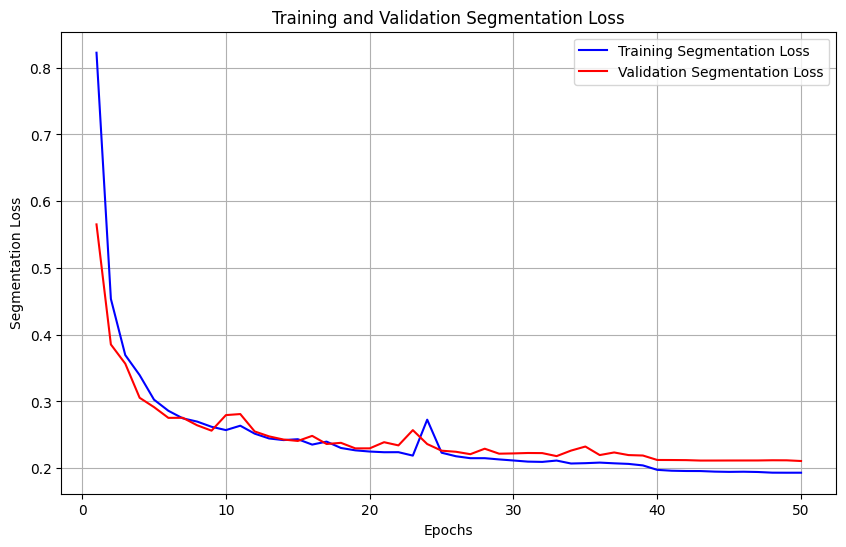

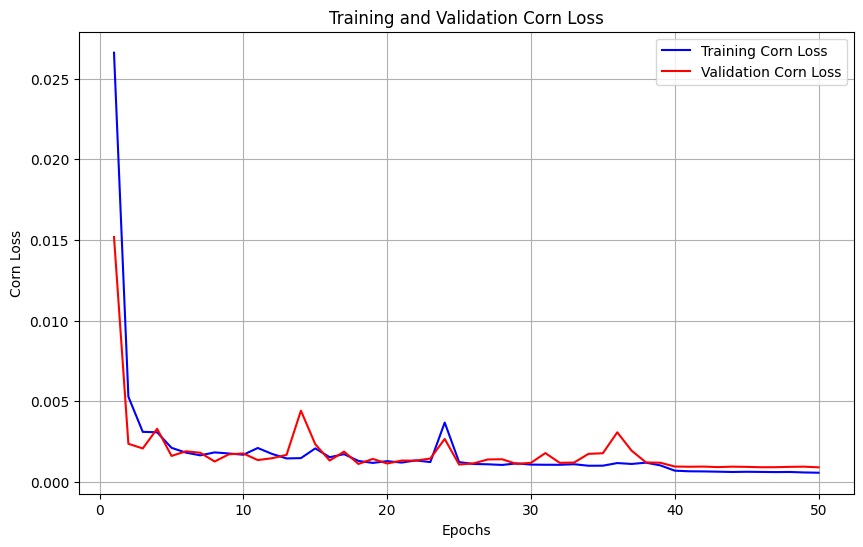

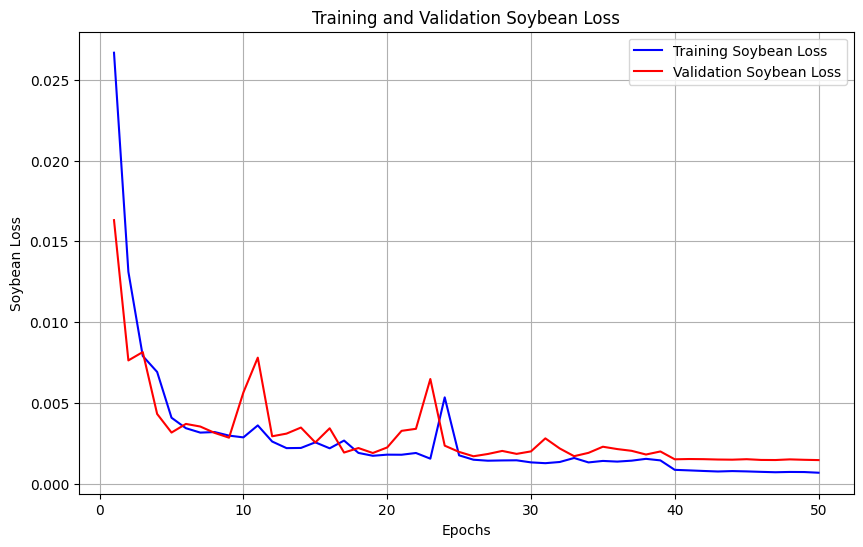

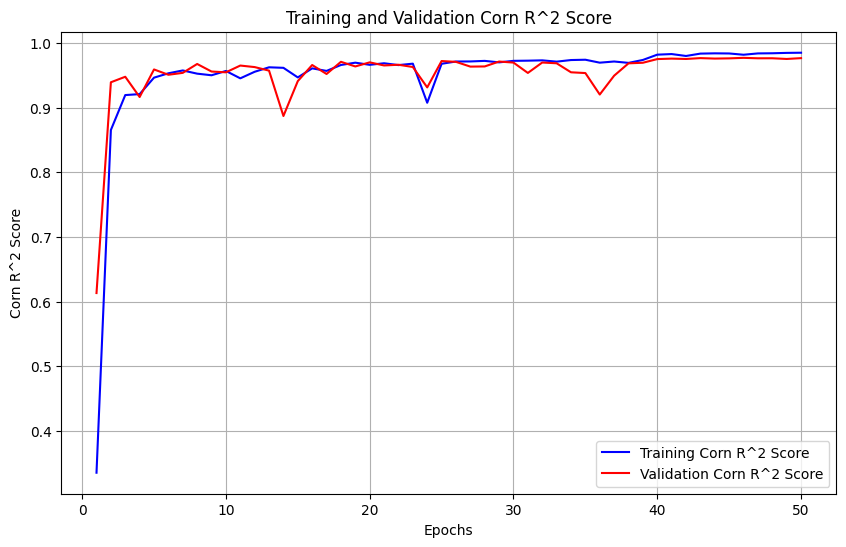

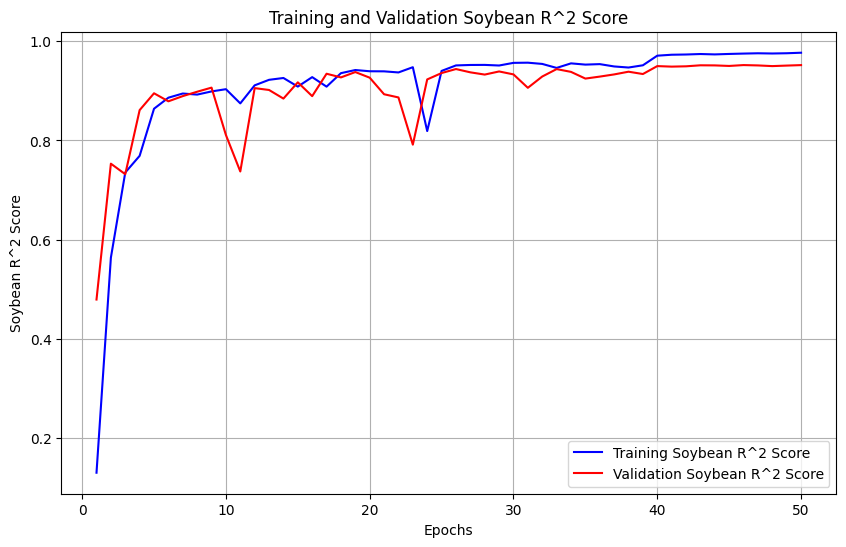

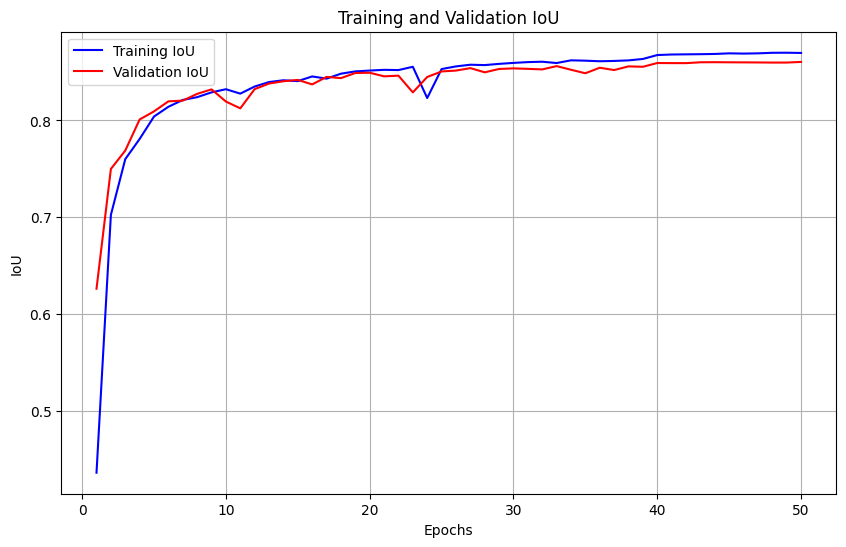

In [14]:
import os
import pandas as pd
from torch.utils.data import Dataset
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Check if CUDA is available and set the default device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')


# Initialize components
num_classes= 3
swin_backbone = SwinTransformer(in_channels=8).to(device)
segmentation_head = SegmentationHead(num_classes=num_classes).to(device)
regression_head = RegressionHead(input_dims=[96, 192, 384, 768]).to(device)

# Create unified model
unified_model = UnifiedModel(swin_backbone, segmentation_head, regression_head).to(device)
model = unified_model
# Use DataParallel for multi-GPU support if available
# if torch.cuda.device_count() > 1:
#     model = nn.DataParallel(model)

model = nn.DataParallel(model)

# Define loss functions
criterion_segmentation = nn.CrossEntropyLoss()
criterion_regression = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

# Define the learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Define Early Stopping
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0, checkpoint_dir='checkpoints_swin_linear'):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.counter = 0
        self.checkpoint_dir = checkpoint_dir

        if not os.path.exists(self.checkpoint_dir):
            os.makedirs(self.checkpoint_dir)

    def __call__(self, val_loss, model, optimizer, epoch):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, optimizer, epoch)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, optimizer, epoch)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, optimizer, epoch):
        """Saves model and optimizer when validation loss decreases."""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        checkpoint_path = os.path.join(self.checkpoint_dir, f'checkpoint_epoch_{epoch}.pth')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.module.state_dict(),  # Access the underlying model
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss
        }, checkpoint_path)
        self.val_loss_min = val_loss

early_stopper = EarlyStopping(patience=10, verbose=True)

# Define the number of epochs
num_epochs = 50

# Initialize lists to store losses and R² scores
train_losses_seg, val_losses_seg = [], []
train_losses_corn, val_losses_corn = [], []
train_losses_soybean, val_losses_soybean = [], []
train_r2_corn, val_r2_corn = [], []
train_r2_soybean, val_r2_soybean = [], []
train_ious, val_ious = [],[]

# Function to calculate IoU
def calculate_iou(preds, targets, num_classes=3):
    ious = []
    preds = torch.argmax(preds, dim=1).view(-1)
    targets = targets.view(-1)

    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = targets == cls
        intersection = (pred_inds & target_inds).long().sum().item()
        union = (pred_inds | target_inds).long().sum().item()

        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(intersection / union)

    return np.nanmean(ious)  # Average IoU across classes

# Function to get current learning rate
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# Plotting functions
def plot_losses(train_losses, val_losses, loss_type, filename):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, 'b', label=f'Training {loss_type} Loss')
    plt.plot(epochs, val_losses, 'r', label=f'Validation {loss_type} Loss')
    plt.xlabel('Epochs')
    plt.ylabel(f'{loss_type} Loss')
    plt.legend()
    plt.title(f'Training and Validation {loss_type} Loss')
    plt.grid(True)
    plt.savefig(filename)
    plt.show()

def plot_r2_scores(train_r2, val_r2, crop_type, filename):
    epochs = range(1, len(train_r2) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_r2, 'b', label=f'Training {crop_type} R^2 Score')
    plt.plot(epochs, val_r2, 'r', label=f'Validation {crop_type} R^2 Score')
    plt.xlabel('Epochs')
    plt.ylabel(f'{crop_type} R^2 Score')
    plt.legend()
    plt.title(f'Training and Validation {crop_type} R^2 Score')
    plt.grid(True)
    plt.savefig(filename)
    plt.show()

def plot_iou(train_iou, val_iou, filename):
    epochs = range(1, len(train_iou) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_iou, 'b', label='Training IoU')
    plt.plot(epochs, val_iou, 'r', label='Validation IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()
    plt.title('Training and Validation IoU')
    plt.grid(True)
    plt.savefig(filename)
    plt.show()

# Training and validation loop
with open('loss_log_swin_linear.txt', 'w') as f:
    f.write("Epoch,Train Seg Loss,Train IoU,Val Seg Loss,Val IoU,Train Corn Loss,Train Soybean Loss,Val Corn Loss,Val Soybean Loss,Train Corn R2,Train Soybean R2,Val Corn R2,Val Soybean R2,Learning Rate\n")

    for epoch in range(num_epochs):
        model.train()
        train_loss_seg, train_iou = 0.0, 0.0
        train_loss_corn, train_loss_soybean = 0.0, 0.0
        total_train_r2_corn, total_train_r2_soybean = 0.0, 0.0
        for images, targets, yields in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
            corn_yield, soybean_yield = yields
            images, targets = images.to(device).float(), targets.to(device).long()
            corn_yield, soybean_yield = corn_yield.to(device), soybean_yield.to(device)

            optimizer.zero_grad()
            seg_output, pred_corn_yield, pred_soybean_yield = model(images)

            loss_segmentation = criterion_segmentation(seg_output, targets.squeeze(1))  # Squeeze the targets
            loss_corn_yield = criterion_regression(pred_corn_yield.view(-1), corn_yield)
            loss_soybean_yield = criterion_regression(pred_soybean_yield.view(-1), soybean_yield)

            loss = loss_segmentation + loss_corn_yield + loss_soybean_yield
            loss.backward()
            optimizer.step()

            train_loss_seg += loss_segmentation.item()
            train_loss_corn += loss_corn_yield.item()
            train_loss_soybean += loss_soybean_yield.item()
            train_iou += calculate_iou(seg_output, targets)
            total_train_r2_corn += r2_score(corn_yield.cpu().numpy(), pred_corn_yield.view(-1).cpu().detach().numpy())
            total_train_r2_soybean += r2_score(soybean_yield.cpu().numpy(), pred_soybean_yield.view(-1).cpu().detach().numpy())

        train_losses_seg.append(train_loss_seg / len(train_loader))
        train_ious.append(train_iou / len(train_loader))
        train_losses_corn.append(train_loss_corn / len(train_loader))
        train_losses_soybean.append(train_loss_soybean / len(train_loader))
        train_r2_corn.append(total_train_r2_corn / len(train_loader))
        train_r2_soybean.append(total_train_r2_soybean / len(train_loader))

        model.eval()
        val_loss_seg, val_iou = 0.0, 0.0
        val_loss_corn, val_loss_soybean = 0.0, 0.0
        total_val_r2_corn, total_val_r2_soybean = 0.0, 0.0
        with torch.no_grad():
            for images, targets, yields in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
                corn_yield, soybean_yield = yields
                images, targets = images.to(device).float(), targets.to(device).long()
                corn_yield, soybean_yield = corn_yield.to(device), soybean_yield.to(device)

                seg_output, pred_corn_yield, pred_soybean_yield = model(images)

                loss_segmentation = criterion_segmentation(seg_output, targets.squeeze(1))  # Squeeze the targets
                loss_corn_yield = criterion_regression(pred_corn_yield.view(-1), corn_yield)
                loss_soybean_yield = criterion_regression(pred_soybean_yield.view(-1), soybean_yield)

                loss = loss_segmentation + loss_corn_yield + loss_soybean_yield
                val_loss_seg += loss_segmentation.item()
                val_loss_corn += loss_corn_yield.item()
                val_loss_soybean += loss_soybean_yield.item()
                val_iou += calculate_iou(seg_output, targets)
                total_val_r2_corn += r2_score(corn_yield.cpu().numpy(), pred_corn_yield.view(-1).cpu().detach().numpy())
                total_val_r2_soybean += r2_score(soybean_yield.cpu().numpy(), pred_soybean_yield.view(-1).cpu().detach().numpy())

        val_losses_seg.append(val_loss_seg / len(val_loader))
        val_ious.append(val_iou / len(val_loader))
        val_losses_corn.append(val_loss_corn / len(val_loader))
        val_losses_soybean.append(val_loss_soybean / len(val_loader))
        val_r2_corn.append(total_val_r2_corn / len(val_loader))
        val_r2_soybean.append(total_val_r2_soybean / len(val_loader))

        current_lr = get_lr(optimizer)

        print(f'Epoch {epoch+1}, Train Seg Loss: {train_losses_seg[-1]:.4f}, Train IoU: {train_ious[-1]:.4f}, Val Seg Loss: {val_losses_seg[-1]:.4f}, Val IoU: {val_ious[-1]:.4f}')
        print(f'          Train Corn Loss: {train_losses_corn[-1]:.4f}, Train Soybean Loss: {train_losses_soybean[-1]:.4f}')
        print(f'          Val Corn Loss: {val_losses_corn[-1]:.4f}, Val Soybean Loss: {val_losses_soybean[-1]:.4f}')
        print(f'          Train Corn R2: {train_r2_corn[-1]:.4f}, Train Soybean R2: {train_r2_soybean[-1]:.4f}')
        print(f'          Val Corn R2: {val_r2_corn[-1]:.4f}, Val Soybean R2: {val_r2_soybean[-1]:.4f}')
        print(f'          Learning Rate: {current_lr:.6f}')

        f.write(f"{epoch+1},{train_losses_seg[-1]:.4f},{train_ious[-1]:.4f},{val_losses_seg[-1]:.4f},{val_ious[-1]:.4f},{train_losses_corn[-1]:.4f},{train_losses_soybean[-1]:.4f},{val_losses_corn[-1]:.4f},{val_losses_soybean[-1]:.4f},{train_r2_corn[-1]:.4f},{train_r2_soybean[-1]:.4f},{val_r2_corn[-1]:.4f},{val_r2_soybean[-1]:.4f},{current_lr:.6f}\n")

        # Save checkpoint every epoch
        early_stopper.save_checkpoint(val_losses_seg[-1], model, optimizer, epoch)

        # Step the scheduler
        scheduler.step(val_losses_seg[-1])

        # Early stopping check
        early_stopper(val_losses_seg[-1], model, optimizer, epoch)
        if early_stopper.early_stop:
            print("Early stopping triggered.")
            break

# Plotting the losses and R2 scores
plot_losses(train_losses_seg, val_losses_seg, 'Segmentation', 'checkpoints_swin_linear/train_val_segmentation_loss.png')
plot_losses(train_losses_corn, val_losses_corn, 'Corn', 'checkpoints_swin_linear/train_val_corn_loss.png')
plot_losses(train_losses_soybean, val_losses_soybean, 'Soybean', 'checkpoints_swin_linear/train_val_soybean_loss.png')
plot_r2_scores(train_r2_corn, val_r2_corn, 'Corn', 'checkpoints_swin_linear/train_val_corn_r2.png')
plot_r2_scores(train_r2_soybean, val_r2_soybean, 'Soybean', 'checkpoints_swin_linear/train_val_soybean_r2.png')
plot_iou(train_ious, val_ious, 'checkpoints_swin_linear/train_val_iou.png')


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [13]:
# test on MN 22

In [14]:
# Function to calculate IoU
def calculate_iou(preds, targets, num_classes=3):
    ious = []
    preds = torch.argmax(preds, dim=1).view(-1)
    targets = targets.view(-1)

    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = targets == cls
        intersection = (pred_inds & target_inds).long().sum().item()
        union = (pred_inds | target_inds).long().sum().item()

        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(intersection / union)

    return np.nanmean(ious)  # Average IoU across classes


Loaded checkpoint from epoch 49 with validation loss 0.2108
Test Loss: 0.2874, Test IoU: 0.7991
Test Pixel Accuracy: 0.9022
Test Mean Pixel Accuracy: 0.8892
Test Dice Coefficient: 0.8870
Test Corn Loss: 0.0040
Test Soybean Loss: 0.0056
R^2 Score for Corn Yield: 0.9131
R^2 Score for Soybean Yield: 0.7858


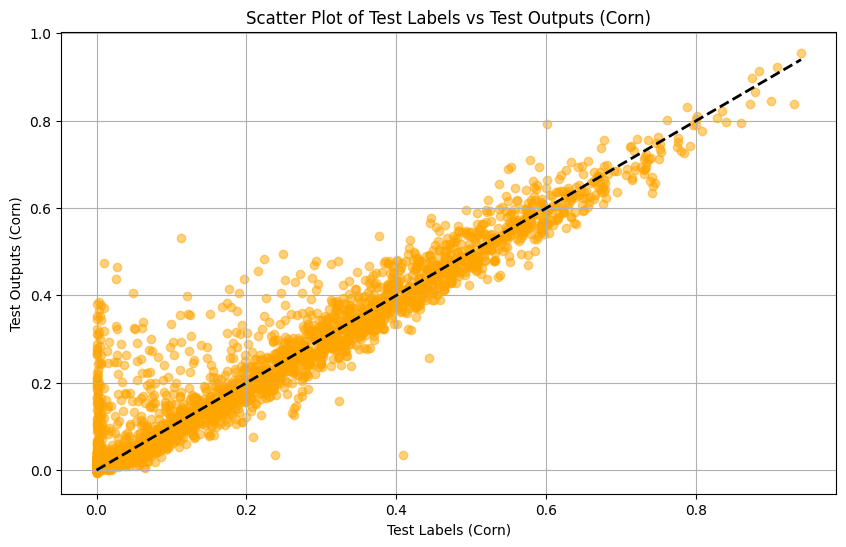

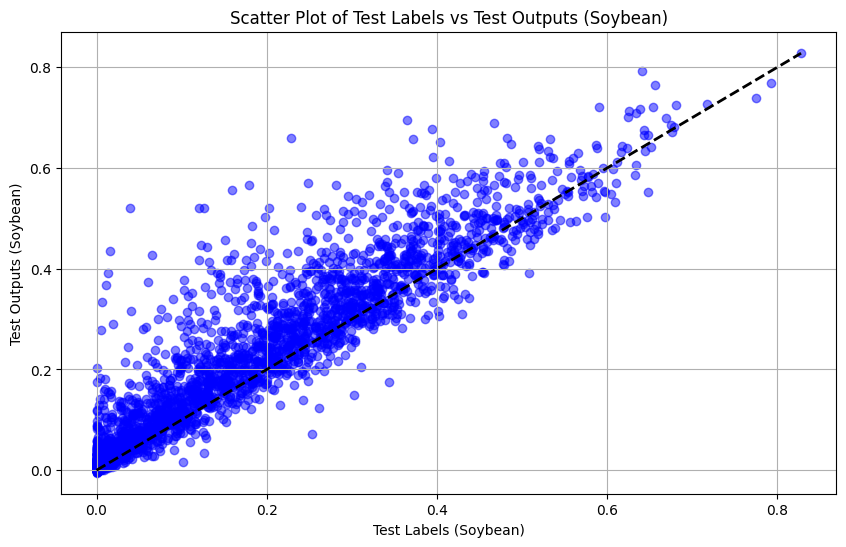

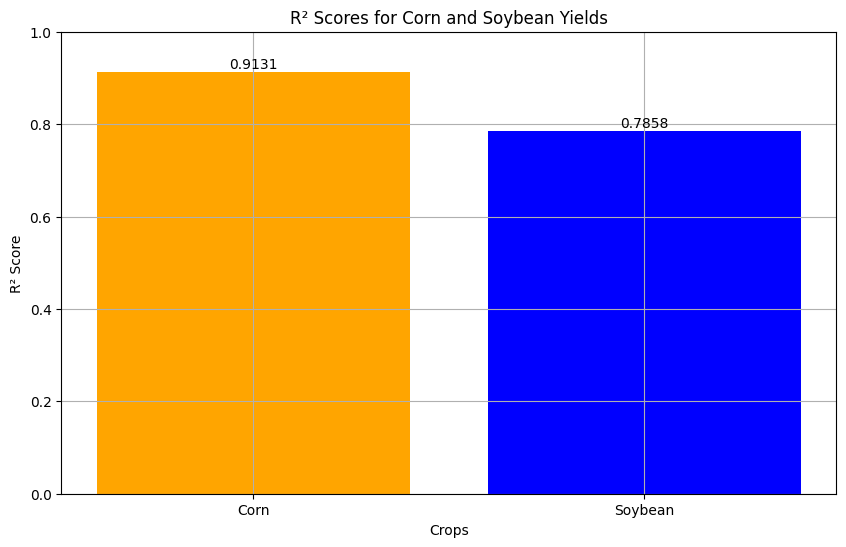

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import pandas as pd  # Add this import

def load_checkpoint(model, checkpoint_path, device):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    state_dict = checkpoint['model_state_dict']

    # Check if the model is wrapped in nn.DataParallel
    if 'module.' in list(state_dict.keys())[0]:
        new_state_dict = {}
        for k, v in state_dict.items():
            if k.startswith('module.'):
                new_state_dict[k[7:]] = v
            else:
                new_state_dict[k] = v
        model.load_state_dict(new_state_dict)
    else:
        # Model was not wrapped in nn.DataParallel during training
        new_state_dict = {}
        for k, v in state_dict.items():
            new_state_dict[f'module.{k}'] = v
        model.load_state_dict(new_state_dict)

    print(f"Loaded checkpoint from epoch {checkpoint['epoch']} with validation loss {checkpoint['val_loss']:.4f}")

def pixel_accuracy(output, target):
    _, predicted = torch.max(output, 1)
    correct = (predicted == target).sum().item()
    total = target.numel()
    return correct / total

def mean_pixel_accuracy(output, target, num_classes):
    _, predicted = torch.max(output, 1)
    mean_acc = 0
    for i in range(num_classes):
        class_mask = (target == i)
        correct = ((predicted == i) & class_mask).sum().item()
        total = class_mask.sum().item()
        if total == 0:
            continue
        mean_acc += correct / total
    return mean_acc / num_classes

def dice_coefficient(output, target, num_classes=3):
    smooth = 1e-6
    _, predicted = torch.max(output, 1)
    dice = 0.0

    for i in range(num_classes):
        pred_i = (predicted == i).float()
        target_i = (target == i).float()
        intersection = (pred_i * target_i).sum().item()
        union = pred_i.sum().item() + target_i.sum().item()
        dice += (2. * intersection + smooth) / (union + smooth)
    
    return dice / num_classes

def evaluate_model(model, test_loader, device):
    model.eval()

    # Define metrics to track
    test_loss = 0.0
    test_iou = 0.0
    test_pixel_acc = 0.0
    test_mean_pixel_acc = 0.0
    test_dice = 0.0
    test_corn_loss = 0.0
    test_soybean_loss = 0.0
    test_segmentation_criterion = nn.CrossEntropyLoss()
    test_regression_criterion = nn.MSELoss()
    num_classes = 3  # Adjust based on your specific number of classes

    # Tracking arrays for yield predictions and actual yields
    all_pred_corn_yields = []
    all_true_corn_yields = []
    all_pred_soybean_yields = []
    all_true_soybean_yields = []

    # Add index tracking
    indices = []

    # Testing loop
    with torch.no_grad():
        for idx, (images, targets, yields) in enumerate(test_loader):
            corn_yield, soybean_yield = yields
            images, targets = images.to(device).float(), targets.to(device).long()
            corn_yield, soybean_yield = corn_yield.to(device), soybean_yield.to(device)

            # Remove the channel dimension from targets
            targets = targets.squeeze(1)

            seg_output, pred_corn_yield, pred_soybean_yield = model(images)

            # Ensure predicted yields retain their dimensions
            pred_corn_yield = pred_corn_yield.view(-1)
            pred_soybean_yield = pred_soybean_yield.view(-1)

            loss_segmentation = test_segmentation_criterion(seg_output, targets)
            loss_corn_yield = test_regression_criterion(pred_corn_yield, corn_yield)
            loss_soybean_yield = test_regression_criterion(pred_soybean_yield, soybean_yield)

            loss = loss_segmentation +  loss_corn_yield +  loss_soybean_yield
            test_loss += loss.item()
            test_iou += calculate_iou(seg_output, targets)
            test_pixel_acc += pixel_accuracy(seg_output, targets)
            test_mean_pixel_acc += mean_pixel_accuracy(seg_output, targets, num_classes)
            test_dice += dice_coefficient(seg_output, targets)
            test_corn_loss += loss_corn_yield.item()
            test_soybean_loss += loss_soybean_yield.item()

            # Store predictions, actual yields, and indices
            all_pred_corn_yields.extend(pred_corn_yield.cpu().numpy())
            all_true_corn_yields.extend(corn_yield.cpu().numpy())
            all_pred_soybean_yields.extend(pred_soybean_yield.cpu().numpy())
            all_true_soybean_yields.extend(soybean_yield.cpu().numpy())
            indices.extend([idx] * len(pred_corn_yield))

    # Calculate average test loss and metrics
    test_loss /= len(test_loader)
    test_iou /= len(test_loader)
    test_pixel_acc /= len(test_loader)
    test_mean_pixel_acc /= len(test_loader)
    test_dice /= len(test_loader)
    test_corn_loss /= len(test_loader)
    test_soybean_loss /= len(test_loader)

    print(f'Test Loss: {test_loss:.4f}, Test IoU: {test_iou:.4f}')
    print(f'Test Pixel Accuracy: {test_pixel_acc:.4f}')
    print(f'Test Mean Pixel Accuracy: {test_mean_pixel_acc:.4f}')
    print(f'Test Dice Coefficient: {test_dice:.4f}')
    print(f'Test Corn Loss: {test_corn_loss:.4f}')
    print(f'Test Soybean Loss: {test_soybean_loss:.4f}')

    # Calculate R² score for yield predictions
    r2_corn = r2_score(all_true_corn_yields, all_pred_corn_yields)
    r2_soybean = r2_score(all_true_soybean_yields, all_pred_soybean_yields)

    print(f'R^2 Score for Corn Yield: {r2_corn:.4f}')
    print(f'R^2 Score for Soybean Yield: {r2_soybean:.4f}')

    # Save predictions to CSV
    results_df = pd.DataFrame({
        'Index': indices,
        'True_Corn_Yield': all_true_corn_yields,
        'Predicted_Corn_Yield': all_pred_corn_yields,
        'True_Soybean_Yield': all_true_soybean_yields,
        'Predicted_Soybean_Yield': all_pred_soybean_yields
    })
    results_df.to_csv('predictions_Swin_linear__MN22_40.csv', index=False)

    return (all_true_corn_yields, all_pred_corn_yields,
            all_true_soybean_yields, all_pred_soybean_yields,
            r2_corn, r2_soybean)

def plot_scatter(true_values, pred_values, crop_type, filename):
    plt.figure(figsize=(10, 6))
    color = 'orange' if crop_type == 'Corn' else 'blue'
    plt.scatter(true_values, pred_values, color=color, alpha=0.5)
    plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'k--', linewidth=2)
    plt.title(f'Scatter Plot of Test Labels vs Test Outputs ({crop_type})')
    plt.xlabel(f'Test Labels ({crop_type})')
    plt.ylabel(f'Test Outputs ({crop_type})')
    plt.grid(True)
    plt.savefig(filename)
    plt.show()

def plot_r2_scores(r2_corn, r2_soybean, filename):
    crops = ['Corn', 'Soybean']
    r2_scores = [r2_corn, r2_soybean]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(crops, r2_scores, color=['orange', 'blue'])
    plt.xlabel('Crops')
    plt.ylabel('R² Score')
    plt.title('R² Scores for Corn and Soybean Yields')
    
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', ha='center', va='bottom')
    
    plt.ylim(0, 1)  # Set y-axis limit to range [0, 1]
    plt.grid(True)
    plt.savefig(filename)
    plt.show()

swin_backbone = SwinTransformer(in_channels=8).to(device)
segmentation_head = SegmentationHead(num_classes=3).to(device)
regression_head = RegressionHead(input_dims=[96, 192, 384, 768]).to(device)

# Create unified model
unified_model = UnifiedModel(swin_backbone, segmentation_head, regression_head).to(device)
model = unified_model

model = nn.DataParallel(model)
checkpoint_path = 'checkpoints_swin_linear/checkpoint_epoch_49.pth'
load_checkpoint(model, checkpoint_path, device)

(all_true_corn_yields, all_pred_corn_yields,
 all_true_soybean_yields, all_pred_soybean_yields,
 r2_corn, r2_soybean) = evaluate_model(model, test_loader, device)

# Plot the results
plot_scatter(all_true_corn_yields, all_pred_corn_yields, 'Corn', 'checkpoints_swin_linear/test_labels_vs_outputs_corn_MN22_49.png')
plot_scatter(all_true_soybean_yields, all_pred_soybean_yields, 'Soybean', 'checkpoints_swin_linear/test_labels_vs_outputs_soybean_MN22_49.png')
plot_r2_scores(r2_corn, r2_soybean, 'checkpoints_swin_linear/test_r2_scores_MN22_49.png')


In [ ]:
# test on MN23

In [17]:
#test on test6 Minnesota 2023

img_test = r"/home/jovyan/Thesis/Models_training/Full_Data/Full_correct_data/img_dir/test6"
ann_test = r"/home/jovyan/Thesis/Models_training/Full_Data/Full_correct_data/ann_dir/test6"
crop_test = r"/home/jovyan/Thesis/Models_training/Full_Data/Full_correct_data/ann_dir/test6/normalized_test_yield.csv"
dataset_test = CombinedDataset(img_test, ann_test,crop_test, transform=transform)
test_loader = DataLoader(dataset_test, batch_size=128, shuffle=True, pin_memory=True)

Loaded checkpoint from epoch 40 with validation loss 0.2123
Test Loss: 0.4023, Test IoU: 0.7611
Test Pixel Accuracy: 0.8717
Test Mean Pixel Accuracy: 0.8663
Test Dice Coefficient: 0.8636
Test Corn Loss: 0.0080
Test Soybean Loss: 0.0057
R^2 Score for Corn Yield: 0.7906
R^2 Score for Soybean Yield: 0.7139


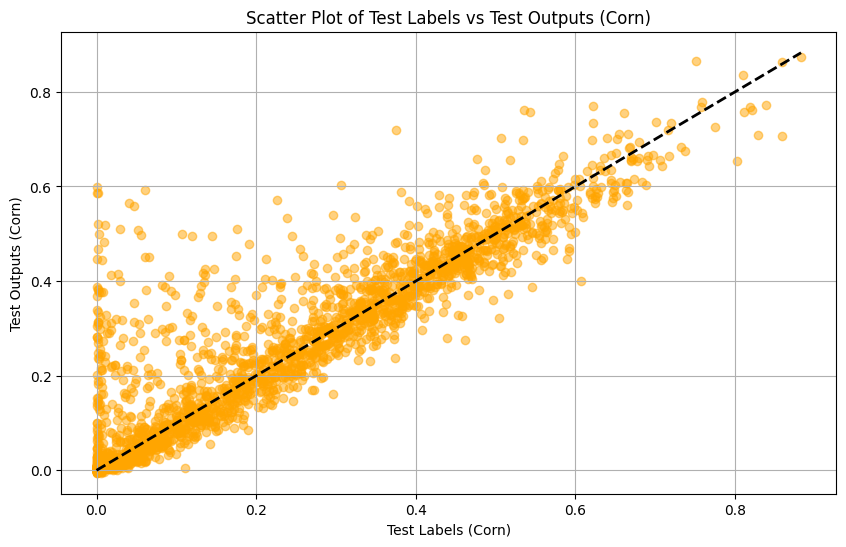

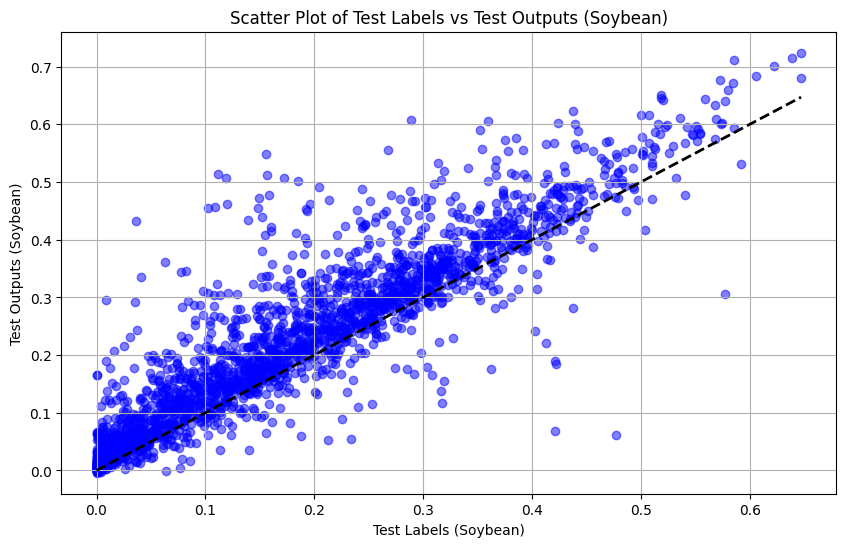

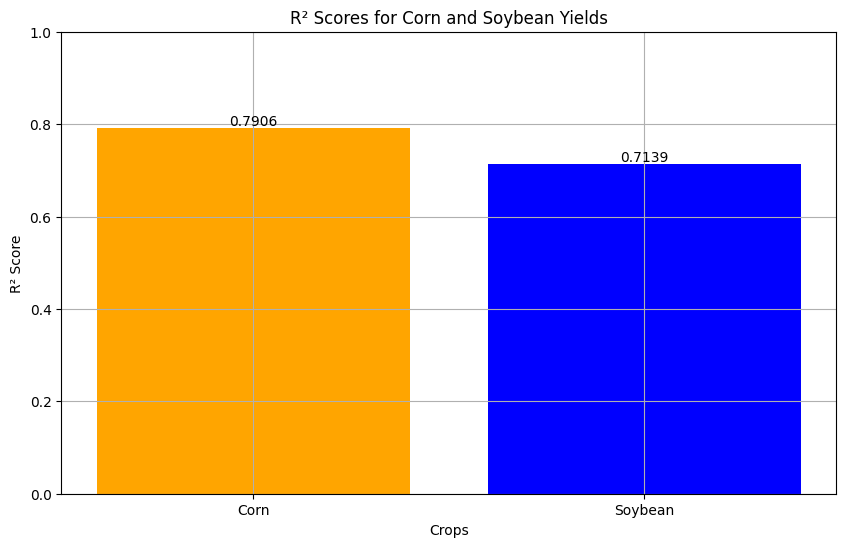

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import pandas as pd  # Add this import

def load_checkpoint(model, checkpoint_path, device):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    state_dict = checkpoint['model_state_dict']

    # Check if the model is wrapped in nn.DataParallel
    if 'module.' in list(state_dict.keys())[0]:
        new_state_dict = {}
        for k, v in state_dict.items():
            if k.startswith('module.'):
                new_state_dict[k[7:]] = v
            else:
                new_state_dict[k] = v
        model.load_state_dict(new_state_dict)
    else:
        # Model was not wrapped in nn.DataParallel during training
        new_state_dict = {}
        for k, v in state_dict.items():
            new_state_dict[f'module.{k}'] = v
        model.load_state_dict(new_state_dict)

    print(f"Loaded checkpoint from epoch {checkpoint['epoch']} with validation loss {checkpoint['val_loss']:.4f}")

def pixel_accuracy(output, target):
    _, predicted = torch.max(output, 1)
    correct = (predicted == target).sum().item()
    total = target.numel()
    return correct / total

def mean_pixel_accuracy(output, target, num_classes):
    _, predicted = torch.max(output, 1)
    mean_acc = 0
    for i in range(num_classes):
        class_mask = (target == i)
        correct = ((predicted == i) & class_mask).sum().item()
        total = class_mask.sum().item()
        if total == 0:
            continue
        mean_acc += correct / total
    return mean_acc / num_classes

def dice_coefficient(output, target, num_classes=3):
    smooth = 1e-6
    _, predicted = torch.max(output, 1)
    dice = 0.0

    for i in range(num_classes):
        pred_i = (predicted == i).float()
        target_i = (target == i).float()
        intersection = (pred_i * target_i).sum().item()
        union = pred_i.sum().item() + target_i.sum().item()
        dice += (2. * intersection + smooth) / (union + smooth)
    
    return dice / num_classes

def evaluate_model(model, test_loader, device):
    model.eval()

    # Define metrics to track
    test_loss = 0.0
    test_iou = 0.0
    test_pixel_acc = 0.0
    test_mean_pixel_acc = 0.0
    test_dice = 0.0
    test_corn_loss = 0.0
    test_soybean_loss = 0.0
    test_segmentation_criterion = nn.CrossEntropyLoss()
    test_regression_criterion = nn.MSELoss()
    num_classes = 3  # Adjust based on your specific number of classes

    # Tracking arrays for yield predictions and actual yields
    all_pred_corn_yields = []
    all_true_corn_yields = []
    all_pred_soybean_yields = []
    all_true_soybean_yields = []

    # Add index tracking
    indices = []

    # Testing loop
    with torch.no_grad():
        for idx, (images, targets, yields) in enumerate(test_loader):
            corn_yield, soybean_yield = yields
            images, targets = images.to(device).float(), targets.to(device).long()
            corn_yield, soybean_yield = corn_yield.to(device), soybean_yield.to(device)

            # Remove the channel dimension from targets
            targets = targets.squeeze(1)

            seg_output, pred_corn_yield, pred_soybean_yield = model(images)

            # Ensure predicted yields retain their dimensions
            pred_corn_yield = pred_corn_yield.view(-1)
            pred_soybean_yield = pred_soybean_yield.view(-1)

            loss_segmentation = test_segmentation_criterion(seg_output, targets)
            loss_corn_yield = test_regression_criterion(pred_corn_yield, corn_yield)
            loss_soybean_yield = test_regression_criterion(pred_soybean_yield, soybean_yield)

            loss = loss_segmentation +  loss_corn_yield +  loss_soybean_yield
            test_loss += loss.item()
            test_iou += calculate_iou(seg_output, targets)
            test_pixel_acc += pixel_accuracy(seg_output, targets)
            test_mean_pixel_acc += mean_pixel_accuracy(seg_output, targets, num_classes)
            test_dice += dice_coefficient(seg_output, targets)
            test_corn_loss += loss_corn_yield.item()
            test_soybean_loss += loss_soybean_yield.item()

            # Store predictions, actual yields, and indices
            all_pred_corn_yields.extend(pred_corn_yield.cpu().numpy())
            all_true_corn_yields.extend(corn_yield.cpu().numpy())
            all_pred_soybean_yields.extend(pred_soybean_yield.cpu().numpy())
            all_true_soybean_yields.extend(soybean_yield.cpu().numpy())
            indices.extend([idx] * len(pred_corn_yield))

    # Calculate average test loss and metrics
    test_loss /= len(test_loader)
    test_iou /= len(test_loader)
    test_pixel_acc /= len(test_loader)
    test_mean_pixel_acc /= len(test_loader)
    test_dice /= len(test_loader)
    test_corn_loss /= len(test_loader)
    test_soybean_loss /= len(test_loader)

    print(f'Test Loss: {test_loss:.4f}, Test IoU: {test_iou:.4f}')
    print(f'Test Pixel Accuracy: {test_pixel_acc:.4f}')
    print(f'Test Mean Pixel Accuracy: {test_mean_pixel_acc:.4f}')
    print(f'Test Dice Coefficient: {test_dice:.4f}')
    print(f'Test Corn Loss: {test_corn_loss:.4f}')
    print(f'Test Soybean Loss: {test_soybean_loss:.4f}')

    # Calculate R² score for yield predictions
    r2_corn = r2_score(all_true_corn_yields, all_pred_corn_yields)
    r2_soybean = r2_score(all_true_soybean_yields, all_pred_soybean_yields)

    print(f'R^2 Score for Corn Yield: {r2_corn:.4f}')
    print(f'R^2 Score for Soybean Yield: {r2_soybean:.4f}')

    # Save predictions to CSV
    results_df = pd.DataFrame({
        'Index': indices,
        'True_Corn_Yield': all_true_corn_yields,
        'Predicted_Corn_Yield': all_pred_corn_yields,
        'True_Soybean_Yield': all_true_soybean_yields,
        'Predicted_Soybean_Yield': all_pred_soybean_yields
    })
    results_df.to_csv('predictions_Swin_linear__MN23.csv', index=False)

    return (all_true_corn_yields, all_pred_corn_yields,
            all_true_soybean_yields, all_pred_soybean_yields,
            r2_corn, r2_soybean)

def plot_scatter(true_values, pred_values, crop_type, filename):
    plt.figure(figsize=(10, 6))
    color = 'orange' if crop_type == 'Corn' else 'blue'
    plt.scatter(true_values, pred_values, color=color, alpha=0.5)
    plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'k--', linewidth=2)
    plt.title(f'Scatter Plot of Test Labels vs Test Outputs ({crop_type})')
    plt.xlabel(f'Test Labels ({crop_type})')
    plt.ylabel(f'Test Outputs ({crop_type})')
    plt.grid(True)
    plt.savefig(filename)
    plt.show()

def plot_r2_scores(r2_corn, r2_soybean, filename):
    crops = ['Corn', 'Soybean']
    r2_scores = [r2_corn, r2_soybean]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(crops, r2_scores, color=['orange', 'blue'])
    plt.xlabel('Crops')
    plt.ylabel('R² Score')
    plt.title('R² Scores for Corn and Soybean Yields')
    
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', ha='center', va='bottom')
    
    plt.ylim(0, 1)  # Set y-axis limit to range [0, 1]
    plt.grid(True)
    plt.savefig(filename)
    plt.show()

swin_backbone = SwinTransformer(in_channels=8).to(device)
segmentation_head = SegmentationHead(num_classes=3).to(device)
regression_head = RegressionHead(input_dims=[96, 192, 384, 768]).to(device)

# Create unified model
unified_model = UnifiedModel(swin_backbone, segmentation_head, regression_head).to(device)
model = unified_model

model = nn.DataParallel(model)
checkpoint_path = 'checkpoints_swin_linear/checkpoint_epoch_40.pth'
load_checkpoint(model, checkpoint_path, device)

(all_true_corn_yields, all_pred_corn_yields,
 all_true_soybean_yields, all_pred_soybean_yields,
 r2_corn, r2_soybean) = evaluate_model(model, test_loader, device)

# Plot the results
plot_scatter(all_true_corn_yields, all_pred_corn_yields, 'Corn', 'checkpoints_swin_linear/test_labels_vs_outputs_corn_MN23.png')
plot_scatter(all_true_soybean_yields, all_pred_soybean_yields, 'Soybean', 'checkpoints_swin_linear/test_labels_vs_outputs_soybean_MN23.png')
plot_r2_scores(r2_corn, r2_soybean, 'checkpoints_swin_linear/test_r2_scores_MN23.png')


In [ ]:
# Save seg output for visualization

In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.colors import ListedColormap

# Ensure the directory for saving images exists
output_dir = 'checkpoints_swin_linear/visualizations'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Define a custom colormap
cmap = ListedColormap(['black', 'orange', 'blue'])

# Function to visualize sample predictions alongside their ground truth labels
def visualize_predictions(images, targets, outputs, num_samples=3, rgb_channels=(5, 3, 2), output_dir='visualizations'):
    images_np = images.cpu().detach().numpy()
    targets_np = targets.cpu().detach().numpy()
    outputs_np = outputs.cpu().detach().numpy()

    num_samples = min(num_samples, len(images_np))  # Ensure num_samples is not greater than the dataset size

    # Randomly select samples
    sample_indices = np.random.choice(len(images_np), num_samples, replace=False)

    for idx in sample_indices:
        image = images_np[idx]  # Multiply pixel values by 10000
        target = targets_np[idx]
        output = np.argmax(outputs_np[idx], axis=0)

        # Concatenate channels to create RGB image
        rgb_image = np.transpose(image, (1, 2, 0))[:, :, rgb_channels]

        plt.figure(figsize=(15, 5))

        # Plot original image
        plt.subplot(1, 3, 1)
        plt.imshow(rgb_image)
        plt.title("Original Image (x10000)")
        plt.axis('off')

        # Plot ground truth
        plt.subplot(1, 3, 2)
        plt.imshow(target, cmap=cmap, vmin=0, vmax=2)
        plt.title("Ground Truth")
        plt.axis('off')

        # Plot predicted output
        plt.subplot(1, 3, 3)
        plt.imshow(output, cmap=cmap, vmin=0, vmax=2)
        plt.title("Predicted Output")
        plt.axis('off')

        # Save the figure
        save_path = os.path.join(output_dir, f'prediction_{idx}.png')
        plt.savefig(save_path)
        plt.close()

# Visualize sample predictions using specific RGB channels
# visualize_predictions(images, targets, outputs, rgb_channels=(5, 3, 2))

model.eval()
with torch.no_grad():
    for images, targets, yields in test_loader:
        images, targets = images.to(device).float(), targets.to(device).long()
        targets = targets.squeeze(1)  # Remove the channel dimension from targets
        outputs, pred_corn_yield, pred_soybean_yield = model(images)
        
        visualize_predictions(images, targets, outputs, num_samples=5, rgb_channels=(5, 3, 2), output_dir=output_dir)
        break  # Remove this line if you want to visualize more batches

In [18]:
# testing on test (MN23)
